# TUIA - Aprendizaje Automático 1

## Trabajo práctico N°2: Predicción de lluvia en Australia

Integrantes:
- Moresco, Brisa
- Brizuela Cipolletti, Sofía

In [1]:
!pip install shap
!pip install optuna
!pip install pandas==2.1.1 matplotlib==3.8.0 scipy==1.14.0
!pip install geopy
!pip install plotly


In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import loguniform
from pycaret.classification import *
from imblearn.combine import SMOTETomek
from geopy.geocoders import Nominatim
import optuna
import shap
import seaborn as sns

from time import sleep

# Creación de clusters


In [3]:
#https://drive.google.com/file/d/1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ/view?usp=drive_link
!gdown 1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ

Downloading...
From: https://drive.google.com/uc?id=1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ
To: c:\Users\sbriz\Documents\AA1-TP2025-MORESCO_BRIZUELA\weatherAUS.csv

  0%|          | 0.00/14.1M [00:00<?, ?B/s]
  7%|▋         | 1.05M/14.1M [00:00<00:02, 6.29MB/s]
 15%|█▍        | 2.10M/14.1M [00:00<00:01, 6.95MB/s]
 22%|██▏       | 3.15M/14.1M [00:00<00:01, 6.77MB/s]
 30%|██▉       | 4.19M/14.1M [00:01<00:03, 3.21MB/s]
 33%|███▎      | 4.72M/14.1M [00:01<00:04, 1.93MB/s]
 41%|████      | 5.77M/14.1M [00:01<00:02, 2.80MB/s]
 48%|████▊     | 6.82M/14.1M [00:01<00:01, 3.69MB/s]
 56%|█████▌    | 7.86M/14.1M [00:02<00:01, 4.44MB/s]
 67%|██████▋   | 9.44M/14.1M [00:02<00:00, 5.99MB/s]
 74%|███████▍  | 10.5M/14.1M [00:02<00:00, 6.75MB/s]
 82%|████████▏ | 11.5M/14.1M [00:02<00:00, 7.39MB/s]
 89%|████████▉ | 12.6M/14.1M [00:02<00:00, 7.96MB/s]
100%|██████████| 14.1M/14.1M [00:02<00:00, 8.84MB/s]
100%|██████████| 14.1M/14.1M [00:02<00:00, 5.27MB/s]


In [4]:
# Carga del dataset
df = pd.read_csv("weatherAUS.csv")

In [5]:
# Visualización del dataset
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [7]:
df.Location.nunique()

49

In [8]:
def separar_nombre_ciudad(location):
    """Función para insertar espacio en el nombre de una ciudad"""
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', location)

In [9]:
from geopy.extra.rate_limiter import RateLimiter

unique_locations = df["Location"].unique() # Obtenemos las ciudades únicas
ciudades_formateadas = [separar_nombre_ciudad(c) for c in unique_locations] # Aplicamos al array de ciudades únicas

# Usamos 'ciudades_formateadas' en la búsqueda con geopy, pero asociando cada coordenada al nombre original
city_mapping = dict(zip(unique_locations, ciudades_formateadas))

geolocator = Nominatim(user_agent="weatherAUS") # Instanciamos el geolocalizador
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3, error_wait_seconds=2.0)

location_coords = [] # Lista para guardar resultados

# Obtenemos coordenadas para cada ciudad
for nombre_original, nombre_formateado in city_mapping.items():
    try:
        location = geocode(f"{nombre_formateado}, Australia", timeout=10)
        if location:
            location_coords.append((nombre_original, location.latitude, location.longitude))
            print(f"{nombre_original} → {nombre_formateado}: {location.latitude}, {location.longitude}")
        else:
            location_coords.append((nombre_original, None, None))
            print(f"{nombre_original}: No encontrado")
    except Exception as e:
        location_coords.append((nombre_original, None, None))
        print(f"{nombre_original}: Error - {e}")

coords_df = pd.DataFrame(location_coords, columns=["Location", "Latitude", "Longitude"]) # Convertimos a df

df = df.merge(coords_df, on="Location", how="left") # Merge con el dataset original

Albury → Albury: -36.0737734, 146.9135265
BadgerysCreek → Badgerys Creek: -33.8831452, 150.742466
Cobar → Cobar: -31.9666628, 145.3045054
CoffsHarbour → Coffs Harbour: -30.2985996, 153.1094116
Moree → Moree: -29.4617202, 149.8407153
Newcastle → Newcastle: -32.9192953, 151.7795348
NorahHead → Norah Head: -33.2816667, 151.5677778
NorfolkIsland → Norfolk Island: -29.0328038, 167.9483137
Penrith → Penrith: -33.7511954, 150.6941711
Richmond → Richmond: -37.80745, 144.9907213
Sydney → Sydney: -33.8698439, 151.2082848
SydneyAirport → Sydney Airport: -33.9498935, 151.1819682
WaggaWagga → Wagga Wagga: -35.115, 147.3677778
Williamtown → Williamtown: -32.815, 151.8427778
Wollongong → Wollongong: -34.4243941, 150.89385
Canberra → Canberra: -35.2975906, 149.1012676
Tuggeranong → Tuggeranong: -35.4209771, 149.0921341
MountGinini → Mount Ginini: -35.5297437, 148.7725396
Ballarat → Ballarat: -37.5623013, 143.8605645
Bendigo → Bendigo: -36.7590183, 144.2826718
Sale → Sale: -38.1094463, 147.0656717
Melb

In [10]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.073773,146.913526
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.073773,146.913526
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.073773,146.913526
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.073773,146.913526
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.073773,146.913526


Cluster con K-Means

In [11]:
# Obtenemos coordenadas únicas por ciudad
city_coords = df[['Location', 'Latitude', 'Longitude']].drop_duplicates().dropna(subset=['Latitude', 'Longitude'])

# Creamos matriz de coordenadas para clustering
matriz_X = city_coords[['Latitude', 'Longitude']].values

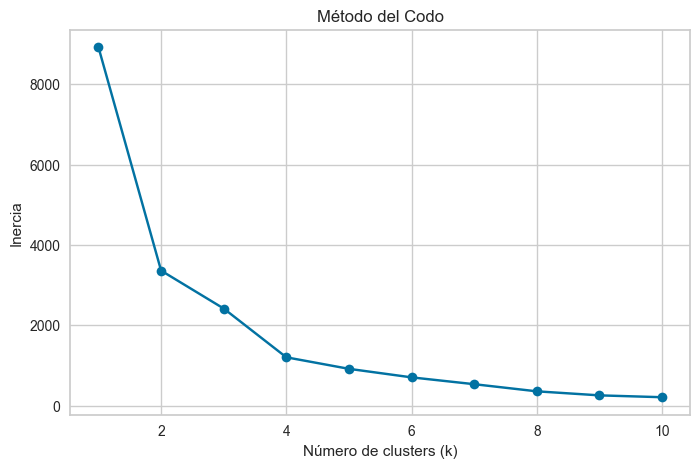

In [12]:
# Implementamos el método del codo

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matriz_X)
    inertia.append(kmeans.inertia_)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

A partir del gráfico podemos observar que el “codo” (el punto donde la curva se empieza a aplanar) sucede cuando k=4

In [13]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
city_coords['Region'] = kmeans.fit_predict(city_coords[['Latitude', 'Longitude']].values)

# Unimos al dataset original
df = df.merge(city_coords[['Location', 'Region']], on='Location', how='left')

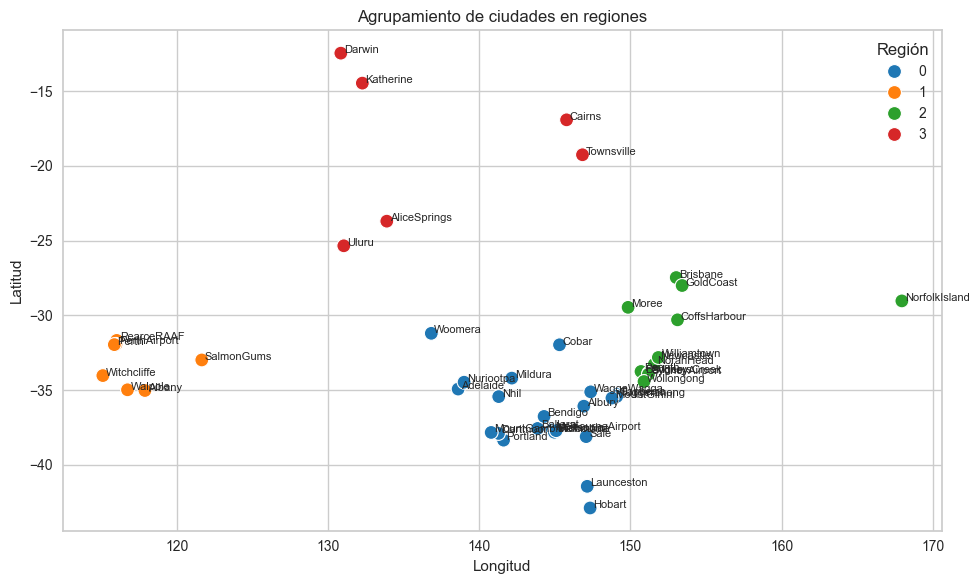

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=city_coords,
    x='Longitude', y='Latitude',
    hue='Region',
    palette='tab10',
    s=100
)

for _, row in city_coords.iterrows():
    plt.text(row['Longitude'] + 0.2, row['Latitude'], row['Location'], fontsize=8)

plt.title('Agrupamiento de ciudades en regiones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

A partir del gráfico podemos observar que las ciudades se agrupan de manera coherente en función de su ubicación geográfica

# Análisis descriptivo y exploratorio

In [15]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude',
       'Region'],
      dtype='object')

El dataset cuenta con las siguientes variables:
1. **Date**: Fecha en la que se realizaron las observaciones meteorológicas
2. **Location**: Ciudad donde se realizó la medición del clima
3. **MinTemp**: Temperatura mínima registrada durante el día (grados Celsius)
4. **MaxTemp**: Temperatura máxima registrada durante el día (grados Celsius)
5. **Rainfall**: Cantidad de precipitación registrada para el día (milímetros)
6. **Evaporation**: Cantidad estimada de agua evaporada en el día (milímetros)
7. **Sunshine**: Cantidad de horas de sol durante el día
8. **WindGustDir**: Dirección del viento en el momento de la ráfaga de viento más fuerte del día
9. **WindGustSpeed**: Velocidad del viento en la ráfaga más fuerte del día (km/h)
10. **WindDir9am**: Dirección del viento a las 9am
11. **WindDir3pm**: Dirección del viento a las 3pm
12. **WindSpeed9am**: Velocidad del viento a las 9am (km/h)
13. **WindSpeed3pm**: Velocidad del viento a las 3pm (km/h)
14. **Humidity9am**: Humedad relativa a las 9am (porcentaje %)
15. **Humidity3pm**: Humedad relativa a las 3pm (porcentaje %)
16. **Pressure9am**: Presión atmosférica las 9am (hectopascales hPa)
17. **Pressure3pm**: Presión atmosférica a las 3pm (hectopascales hPa)
18. **Cloud9am**: Cobertura nubosa a las 9am (octavos)
19. **Cloud3pm**: Cobertura nubosa a las 3pm (octavos)
20. **Temp9am**: Temperatura a las 9am (grados Celsius)
21. **Temp3pm**: Temperatura registrada a las 3pm (grados Celsius)
22. **RainToday**: Variable categórica binaria (Sí/No) que indica si llovió en el día actual
23. **RainTomorrow**: Variable categórica binaria (Sí/No) que indica si lloverá al día siguiente
24. **Latitude**: Latitud geográfica de la ciudad donde se realizó la observación
25. **Longitude**: Longitud geográfica de la ciudad donde se realizó la observación
26. **Region**: Región geográfica asignada a la ciudad según agrupamiento por coordenadas (clusters mediante K-Means)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [17]:
# Verificamos valores faltantes
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
Latitude             0
Longitude            0
Region               0
dtype: int64

In [18]:
# Resumen descriptivo de las variables
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Latitude,Longitude,Region
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,-32.861469,141.960054,1.011825
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,6.035275,12.034143,1.082912
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,-42.882509,115.100477,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,-36.759018,138.599931,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,-34.026335,145.304505,1.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,-31.673960,150.694171,2.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000,-12.460440,167.948314,3.000000


El dataset cuenta con 23 columnas y un total de 145460 registros, siendo la mayoría de las variables de tipo object (variables categóricas) o float64 (variables númericas).

Casi todas las variables tienen valores faltantes, en donde la mayor cantidad se concentra en Sunshine (cantidad de horas de luz solar), Evaporation (evaporación), Cloud9am y Cloud3am (cobertura nubosa).

Las únicas columnas con valores negativos son MinTemp, MaxTemp, Temp9am y Temp3pm. Esto es correcto ya que la temperatura puede ser negativa a diferencia de las demás variables.

Calculamos el porcentaje de valores faltantes por cada variable sobre el total del dataset

In [19]:
nan_cant = df.isnull().sum()
nan_porcentaje = (nan_cant / len(df)) * 100

nan_info = pd.DataFrame({
    'Cantidad': nan_cant,
    'Porcentaje': nan_porcentaje
})

print(nan_info)

               Cantidad  Porcentaje
Date                  0    0.000000
Location              0    0.000000
MinTemp            1485    1.020899
MaxTemp            1261    0.866905
Rainfall           3261    2.241853
Evaporation       62790   43.166506
Sunshine          69835   48.009762
WindGustDir       10326    7.098859
WindGustSpeed     10263    7.055548
WindDir9am        10566    7.263853
WindDir3pm         4228    2.906641
WindSpeed9am       1767    1.214767
WindSpeed3pm       3062    2.105046
Humidity9am        2654    1.824557
Humidity3pm        4507    3.098446
Pressure9am       15065   10.356799
Pressure3pm       15028   10.331363
Cloud9am          55888   38.421559
Cloud3pm          59358   40.807095
Temp9am            1767    1.214767
Temp3pm            3609    2.481094
RainToday          3261    2.241853
RainTomorrow       3267    2.245978
Latitude              0    0.000000
Longitude             0    0.000000
Region                0    0.000000


Decidimos eliminar las filas donde la variable target ('RainTomorrow') sea nula

In [20]:
df = df.dropna(subset=['RainTomorrow'])

Eliminamos las filas donde haya más de 10 variables con valores faltantes

In [21]:
df = df.dropna(thresh=df.shape[1] - 10)

In [22]:
# Convertimos la variable Date a tipo date
df['Date'] = pd.to_datetime(df['Date'])

# Creamos una función para determinar la estación correspondiente a cada fecha,
# ya que no es lo mismo predecir la lluvia en un día de verano que hacerlo en un día de invierno, por decir un ejemplo
def estacion(date):
    mes = date.month
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df['Season'] = df['Date'].apply(estacion)

In [23]:
# Eliminamos la variable Date original
df = df.drop(columns=['Date'])

In [24]:
# Obtener dummies para las columnas RainToday y RainTomorrow
df = pd.get_dummies(df, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df = df.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

In [25]:
print("=== Estadísticas descriptivas (categóricas) ===")
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumna: {col}")
    print(f"- Valores únicos: {df[col].nunique()}")
    print(f"- Frecuencias:\n{df[col].value_counts().head(5)}")
    print(f"- Valores nulos: {df[col].isnull().sum()}")

=== Estadísticas descriptivas (categóricas) ===

Columna: Location
- Valores únicos: 49
- Frecuencias:
Location
Sydney      3337
Canberra    3206
Perth       3193
Darwin      3192
Hobart      3188
Name: count, dtype: int64
- Valores nulos: 0

Columna: WindGustDir
- Valores únicos: 16
- Frecuencias:
WindGustDir
W      9754
SE     9301
E      9058
N      9024
SSE    8989
Name: count, dtype: int64
- Valores nulos: 7725

Columna: WindDir9am
- Valores únicos: 16
- Frecuencias:
WindDir9am
N      11360
SE      9068
E       9014
SSE     8964
S       8488
Name: count, dtype: int64
- Valores nulos: 8715

Columna: WindDir3pm
- Valores únicos: 16
- Frecuencias:
WindDir3pm
SE     10633
W       9884
S       9590
WSW     9306
SW      9171
Name: count, dtype: int64
- Valores nulos: 2226

Columna: Season
- Valores únicos: 4
- Frecuencias:
Season
Otoño        37017
Invierno     35512
Primavera    34089
Verano       33780
Name: count, dtype: int64
- Valores nulos: 0


In [26]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Latitude', 'Longitude', 'Region', 'Season', 'RainToday',
       'RainTomorrow'],
      dtype='object')

In [27]:
# Eliminamos la columna Location ya que no la utilizaremos
df = df.drop(columns=['Location'])

# También eliminamos las columnas Latitude y Longitude ya que no la utilizaremos
df = df.drop(columns=['Latitude', 'Longitude'])

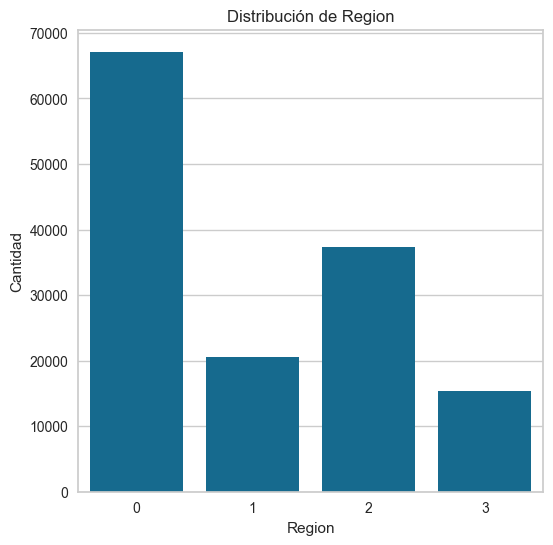

In [28]:
# Distribución de la variable Region
plt.figure(figsize=(6, 6))
sns.countplot(x=df['Region'])
plt.title('Distribución de Region')
plt.xlabel('Region')
plt.ylabel('Cantidad')
plt.show()

In [30]:
# Filtrar las columnas numéricas del dataset
df_numerico = df.select_dtypes(include=['float64', 'int64'])

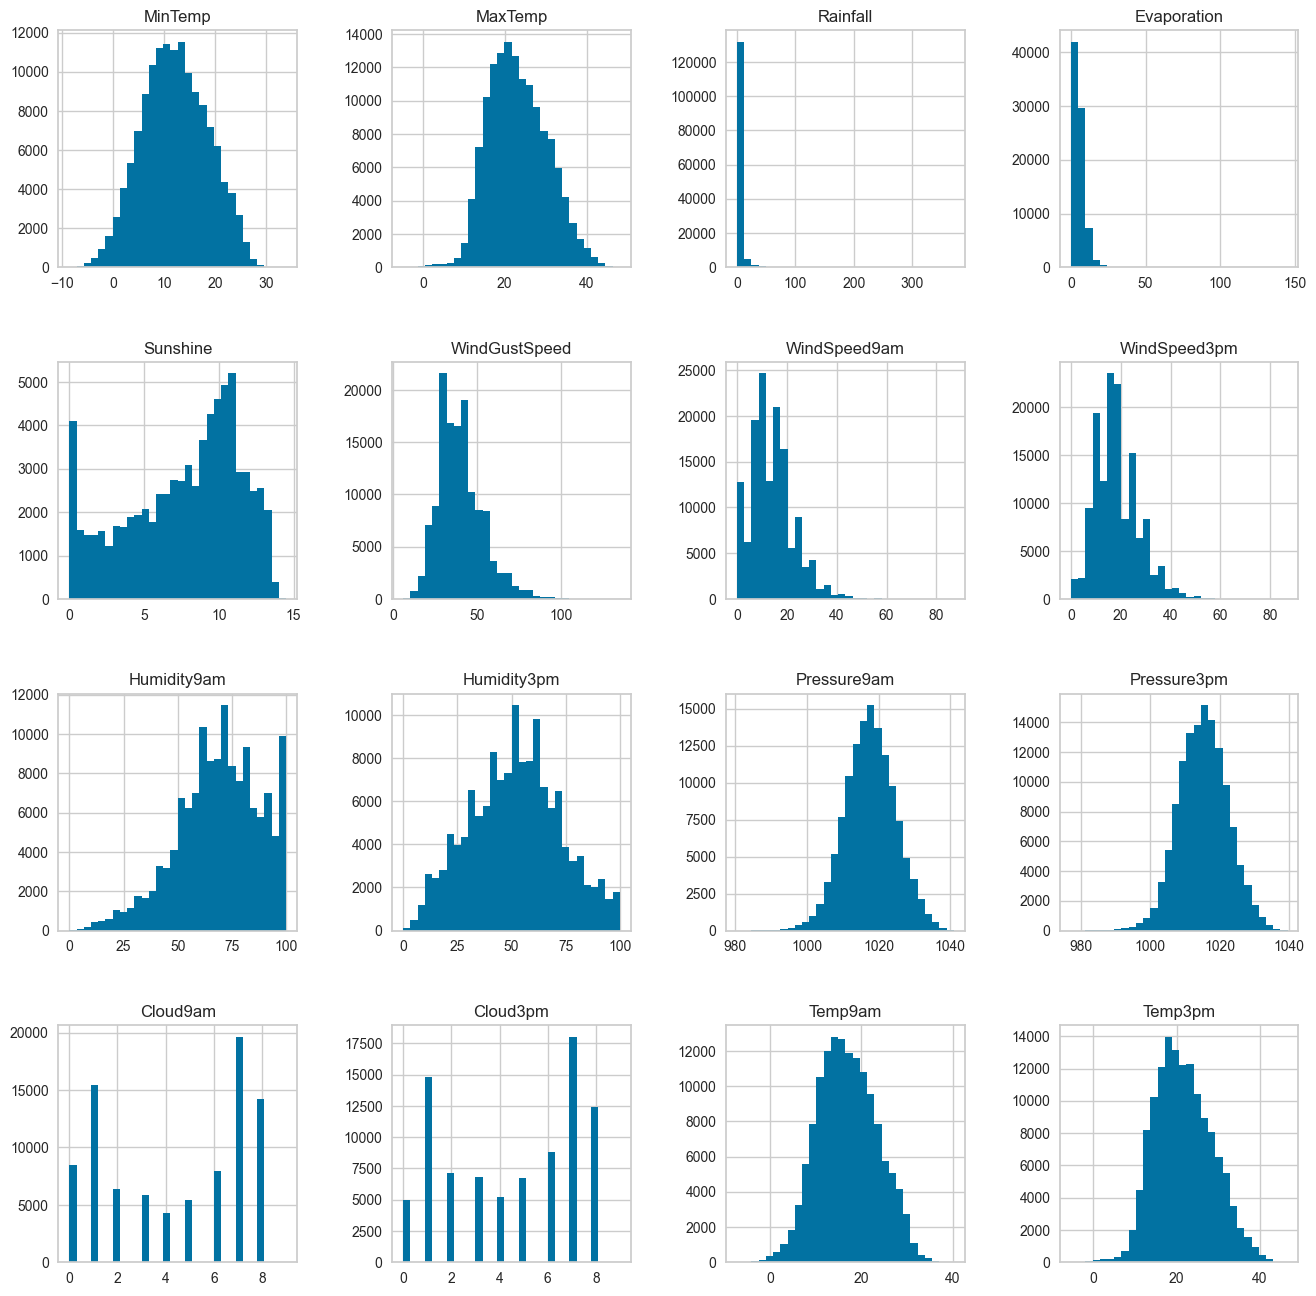

In [31]:
# Determinar la cantidad de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

fig.subplots_adjust(hspace=0.4, wspace=0.4) # Ajustar espacio entre los gráficos

# Iterar sobre las columnas y plotear cada una en su propio subplot (histograma)
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    axes[row, col].hist(df_numerico[column], bins=30)
    axes[row, col].set_title(column)

# Eliminar gráficos vacíos en caso de no completar la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

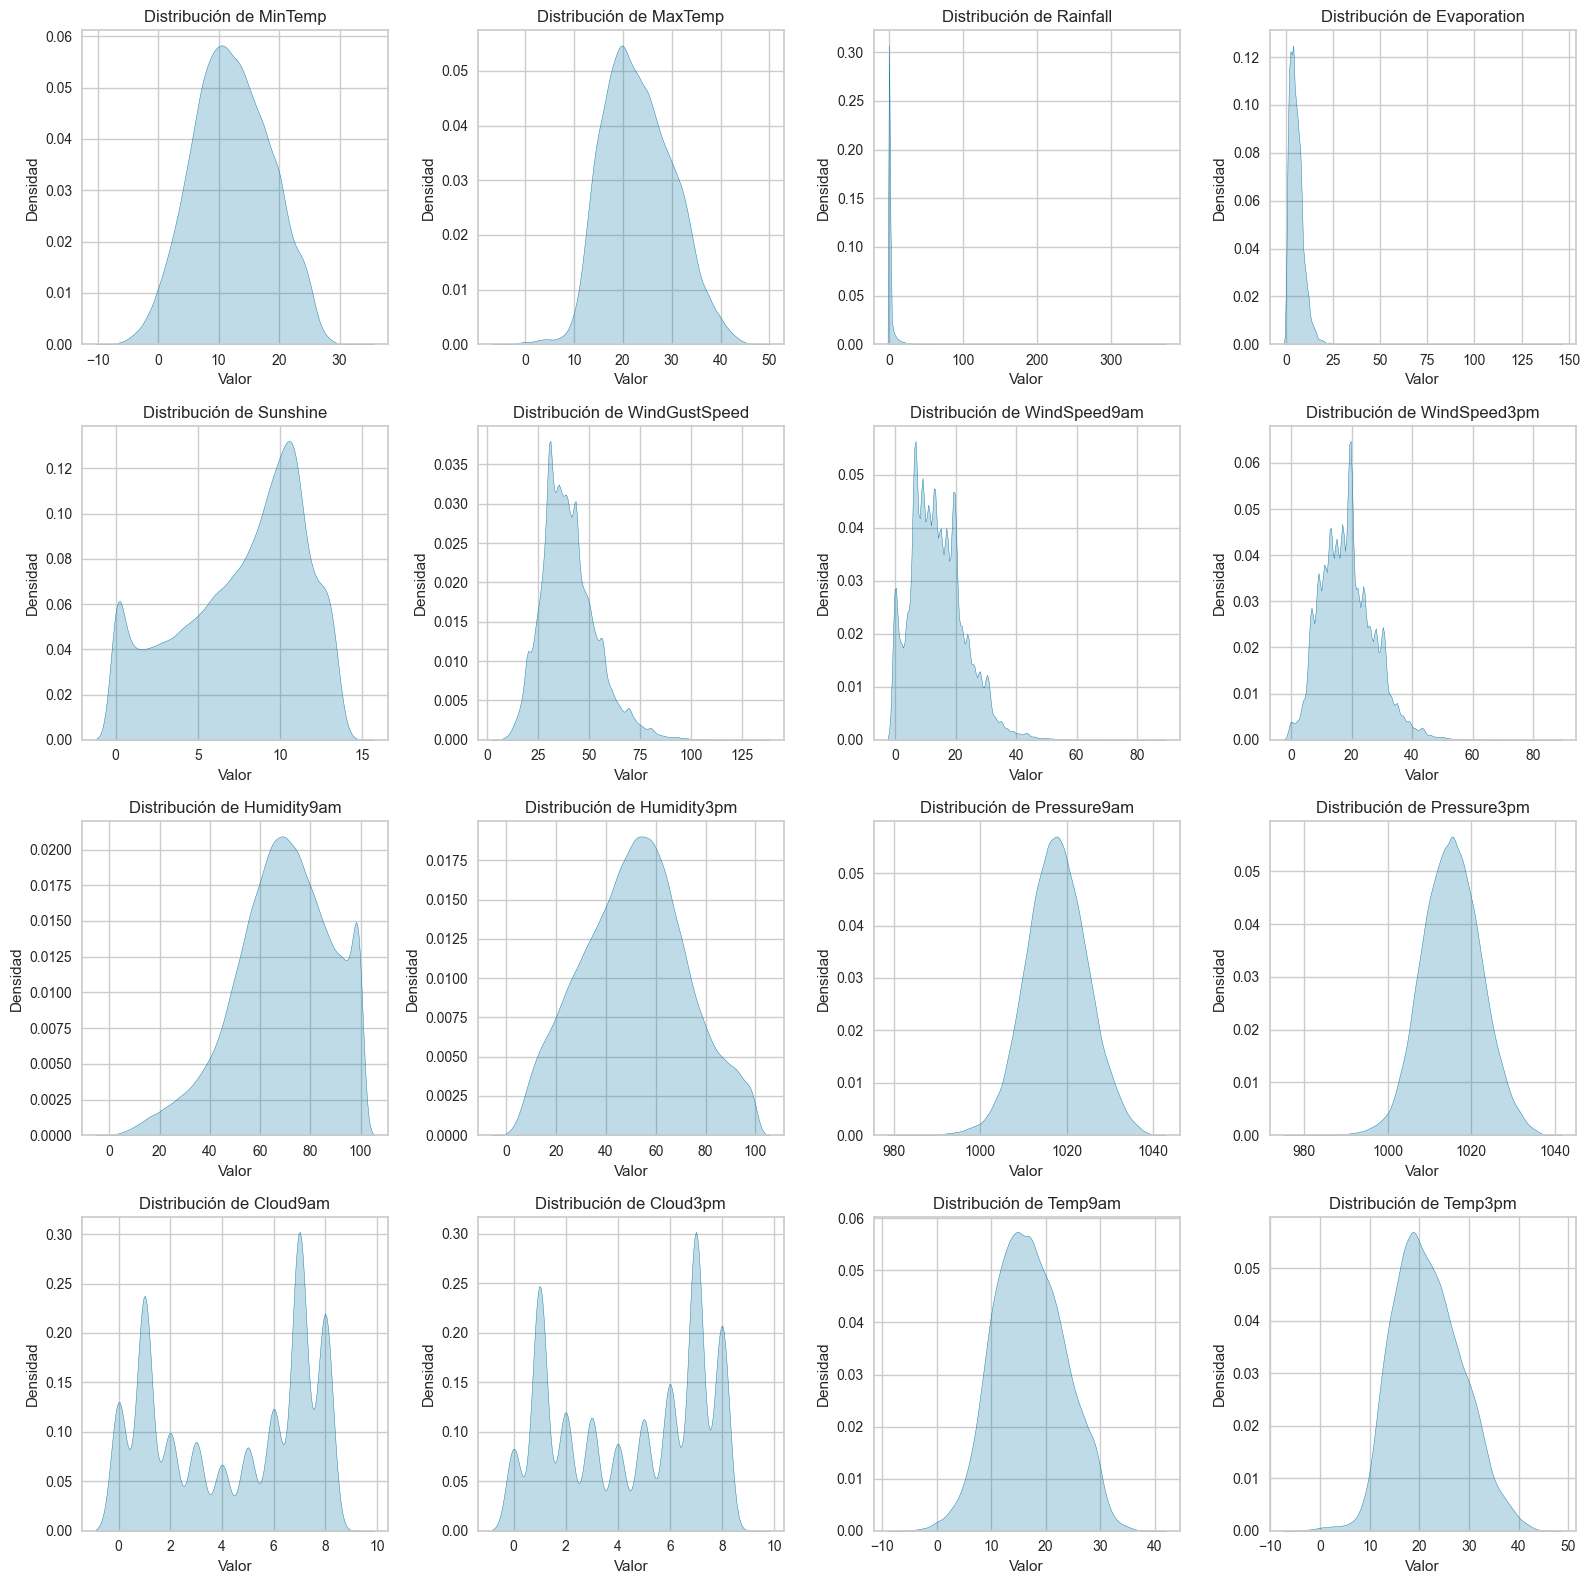

In [32]:
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Graficar densidad por cada variable
for i, column in enumerate(df_numerico.columns):
    sns.kdeplot(data=df_numerico, x=column, ax=axes[i], fill=True)
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Densidad')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

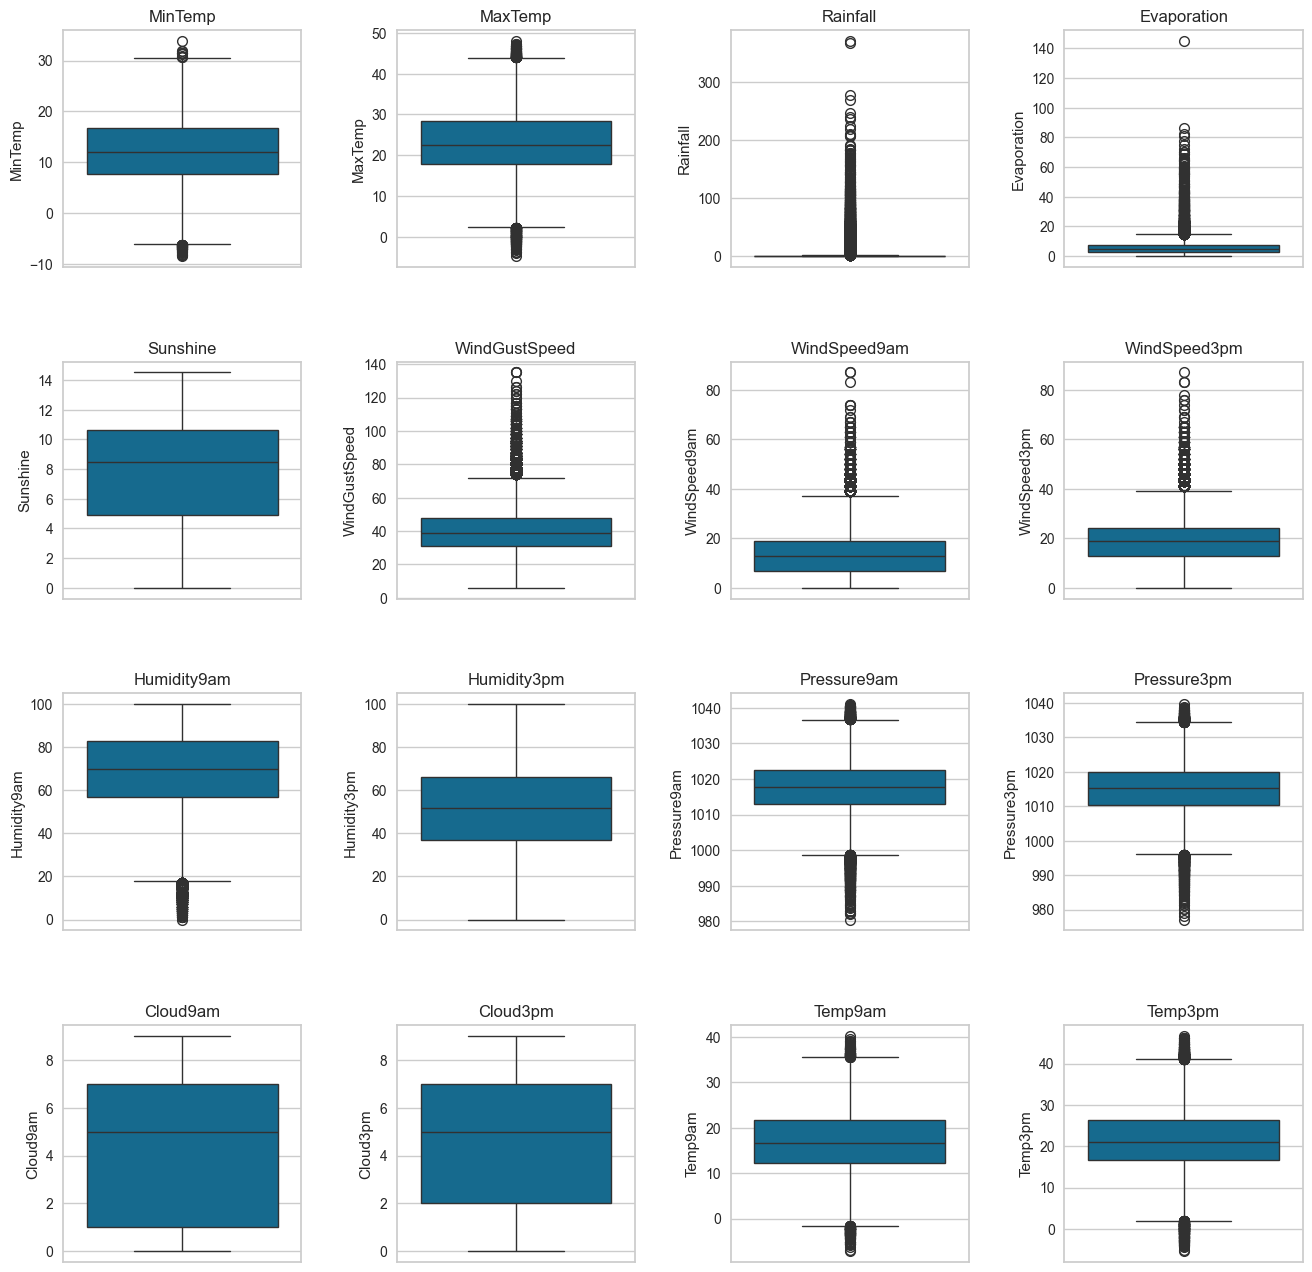

In [33]:
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Graficar boxplot para cada variable
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.boxplot(data=df_numerico, y=column, ax=axes[row, col])
    axes[row, col].set_title(column)

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

Al analizar la distribución y los boxplots de las variables numéricas, podemos observar que hay:
- Distribuciones simétricas (normales): hay gráficos de variables que tienen forma de campana, similar a la de distribución normal
- Distribuciones asimétricas (sesgadas): existen variables que muestran sesgo hacia la izquierda o la derecha
- Outliers: la mayoría de las variables presentan valores atípicos, pero hay que considerar que pueden representar eventos meteorológicos reales
- Distribuciones multimodales: algunas variables cuentan con distribuciones multimodales

In [ ]:
temperature_vars = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
df[temperature_vars].describe()

,MinTemp,MaxTemp,Temp9am,Temp3pm
count,140131.000000,140217.000000,139974.000000,138722.000000
mean,12.189084,23.231610,16.982772,21.695417
std,6.403174,7.116195,6.499842,6.933308
min,-8.500000,-4.800000,-7.200000,-5.400000
25%,7.600000,17.900000,12.300000,16.600000
50%,12.000000,22.600000,16.700000,21.100000
75%,16.800000,28.300000,21.600000,26.400000
max,33.900000,48.100000,40.200000,46.700000


array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>],
       [<Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

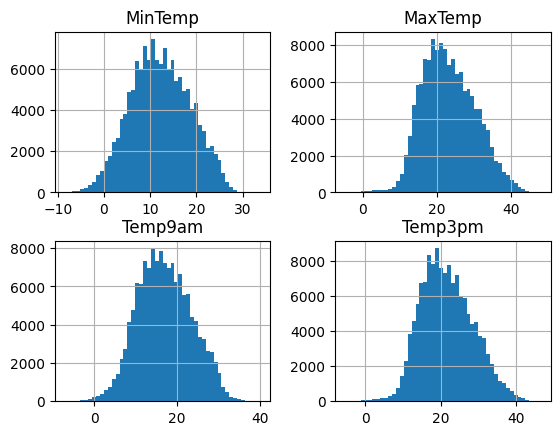

In [ ]:
df[temperature_vars].hist(bins=50)

Se observa que las cuatro variables tienen un comportamiento bastante similar y con distribuciones aproximadamente normales

In [ ]:
humidity_vars = ['Humidity9am', 'Humidity3pm']
df[humidity_vars].describe()

,Humidity9am,Humidity3pm
count,139128.000000,137852.000000
mean,68.824040,51.475278
std,19.073627,20.792876
min,0.000000,0.000000
25%,57.000000,37.000000
50%,70.000000,52.000000
75%,83.000000,66.000000
max,100.000000,100.000000


array([[<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>]], dtype=object)

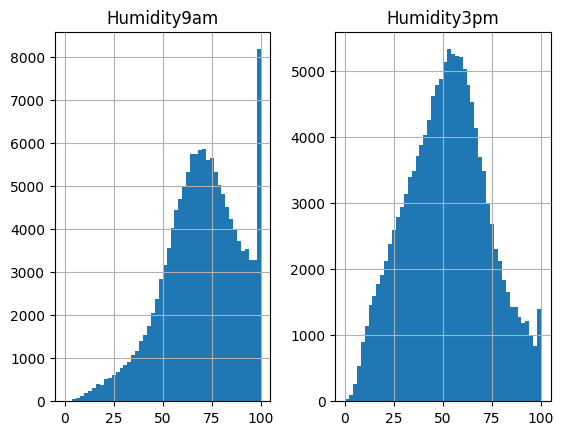

In [ ]:
df[humidity_vars].hist(bins=50)

El rango de valores de las variables de humedad está entre 0 y 100, lo cual es lógico ya que la humedad se mide en porcentaje.

**Humidity9am** está claramente sesgada a la izquierda, con un extremo en 100%, indicando que en muchos días la humedad es total a esa hora.

**Humidity3pm** tiene una distribución más parecida a una campana, aunque levemente sesgada hacia la derecha. Muestra que la humedad suele disminuir a la tarde.

In [ ]:
preassure_vars = ['Pressure9am', 'Pressure3pm']
df[preassure_vars].describe()

,Pressure9am,Pressure3pm
count,128105.000000,128089.000000
mean,1017.653054,1015.258150
std,7.105174,7.036359
min,980.500000,977.100000
25%,1012.900000,1010.400000
50%,1017.600000,1015.200000
75%,1022.400000,1020.000000
max,1041.000000,1039.600000


array([[<Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>]], dtype=object)

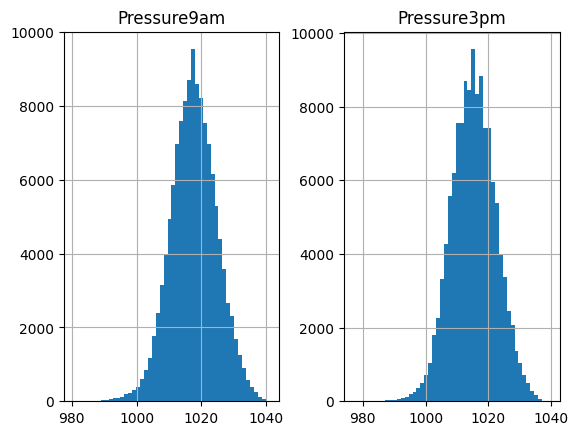

In [ ]:
df[preassure_vars].hist(bins=50)

Ambas variables muestran una distribución muy simétrica, semejante a la normal

In [ ]:
cloud_vars = ['Cloud9am', 'Cloud3pm']
df[cloud_vars].describe()

,Cloud9am,Cloud3pm
count,87768.000000,85033.000000
mean,4.440081,4.503452
std,2.885344,2.720563
min,0.000000,0.000000
25%,1.000000,2.000000
50%,5.000000,5.000000
75%,7.000000,7.000000
max,9.000000,9.000000


array([[<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>]], dtype=object)

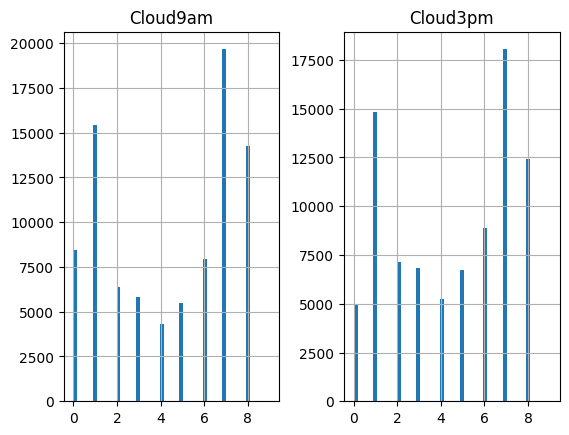

In [ ]:
df[cloud_vars].hist(bins=50)

Las variables de nubosidad son variables discretas, cuentan con valores de 0 a 8, donde:

0 = cielo despejado

8 = cielo completamente cubierto de nubes

Se observa que la variable Cloud9am tiene una distribución bimodal, indicando que, en su mayoría, por la mañana, el cielo tiende a estar o despejado o completamente cubierto. Aunque Cloud3pm tiene un comportamiento similar.

### Boxplots de variables numéricas según la región

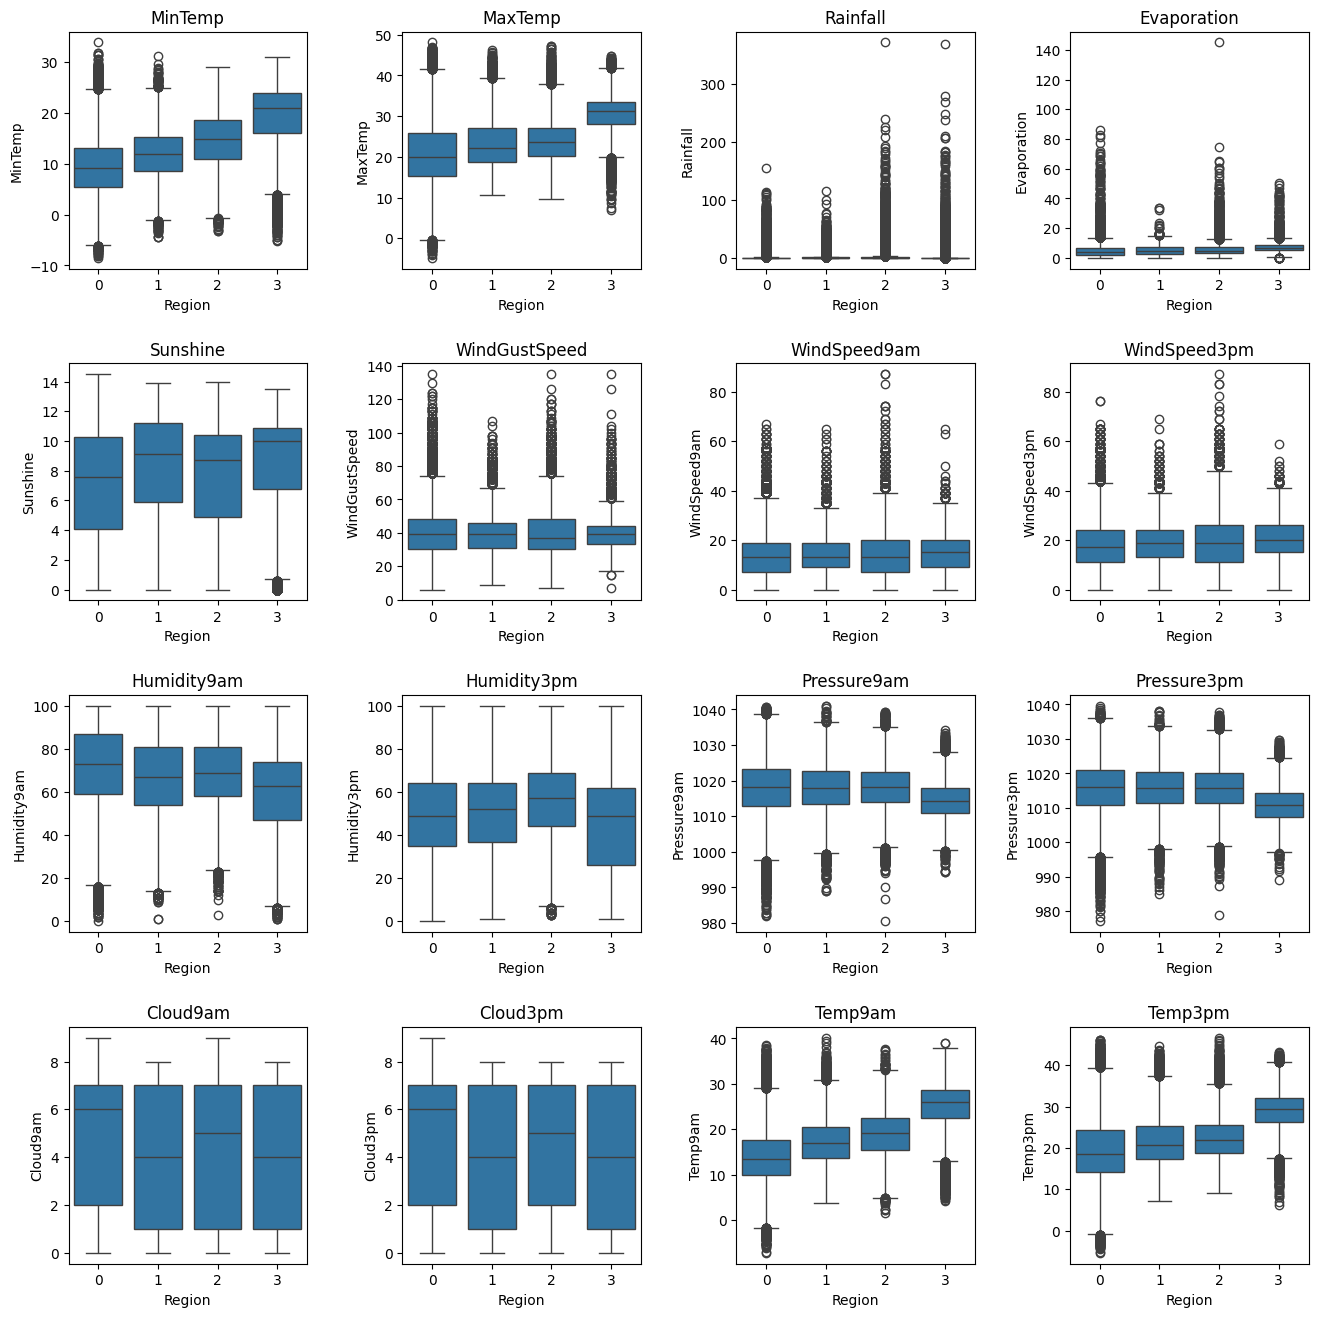

In [ ]:
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df_numerico):
    row, col = divmod(i, 4)
    sns.boxplot(x='Region', data=df, y=column, ax=axes[row, col])
    axes[row, col].set_title(column)

# Eliminar vacíos en caso de no completar la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

A partir de los boxplots de las variables numéricas según la región, podemos analizar que:

- Temperatura (MinTemp, MaxTemp, Temp9am, Temp3pm): La región 0 y 1 parecen tener temperaturas más altas que la región 2, indicando zonas posiblemente más cálidas. Mientras que la región 2 muestra temperaturas más bajas.

- Rainfall: La región 2 muestra mayor variabilidad y valores extremos

- Sunshine: Las regiones 0 y 1 tienen más horas de sol (mayores medianas), mientras que la 2 parece más nublada.

- Wind Variables (WindGustSpeed, WindSpeed9am/3pm): La región 3 muestra velocidades de viento más elevadas.

- Presión (Pressure9am/3pm): Aunque no hay diferencias tan marcadas, la región 1 parece tener presiones atmosféricas ligeramente más altas.

- Cloud9am/Cloud3pm: La región 2 muestra más cobertura nubosa, lo cual coincide con la menor cantidad de sol.

### Boxplots de las variables numéricas en función de la variable target RainTomorrow

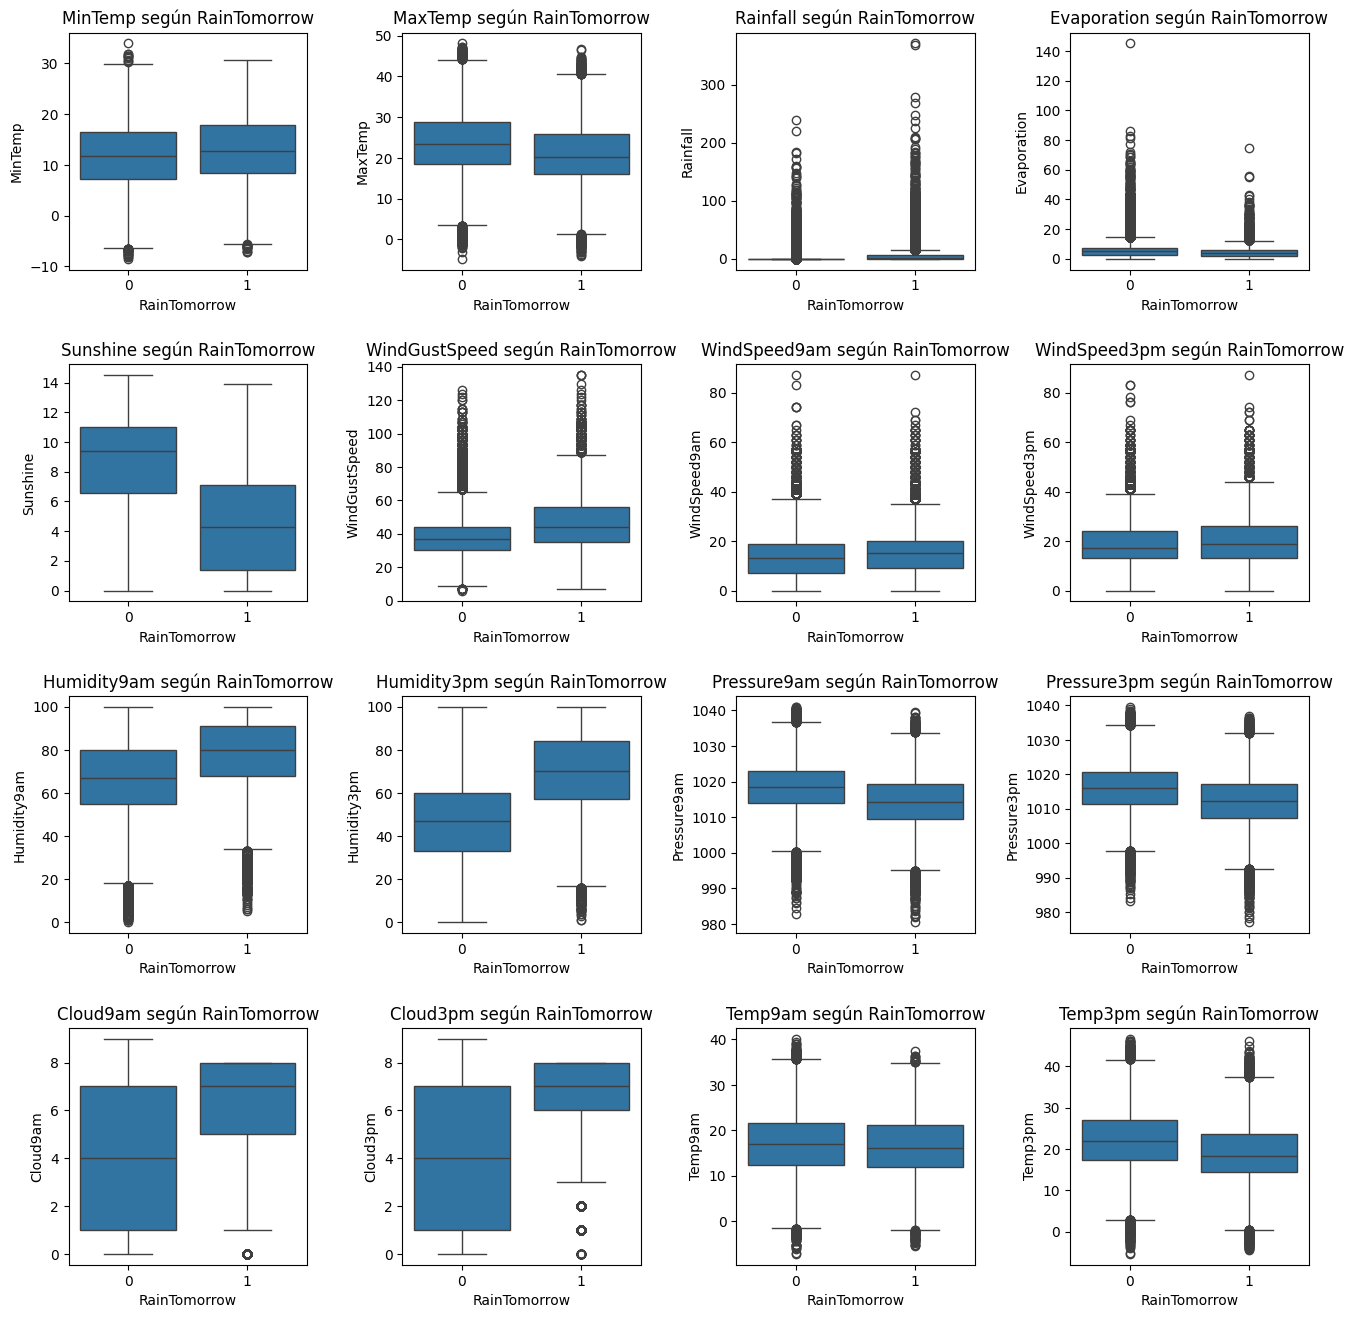

In [ ]:
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df_numerico):
    row, col_idx = divmod(i, 4)
    sns.boxplot(x='RainTomorrow', data=df, y=column, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{column} según RainTomorrow')
    axes[row, col_idx].set_xlabel('RainTomorrow')
    axes[row, col_idx].set_ylabel(column)

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

A partir del análisis de variables numéricas frente a la variable target, podemos deducir que:

- Temperaturas (MinTemp, MaxTemp, Temp9am, Temp3pm): Generalmente más bajas en días que llueve al día siguiente.

- Rainfall y Evaporation: En el día previo a la lluvia, puede haber habido más precipitación y evaporación.

- Sunshine: La cantidad de luz solar es mucho menor en los días previos a la lluvia. Los días soleados se asocian con menos probabilidad de lluvia.

- Vientos (WindGustSpeed, WindSpeed9am, WindSpeed3pm): Tienden a ser más fuertes cuando hay lluvia el día siguiente.

- Humedad (Humidity9am, Humidity3pm): Es mucho mayor en los días previos a la lluvia. Un alto nivel de humedad es un buen predictor de lluvia.

- Presión atmosférica (Pressure9am y Pressure3pm): Ligeramente más baja antes de días con lluvia.

- Nubosidad (Cloud9am y Cloud3pm): Una mayor nubosidad está asociada a mayor probabilidad de lluvia.

### Distribución de la variable target RainTomorrow

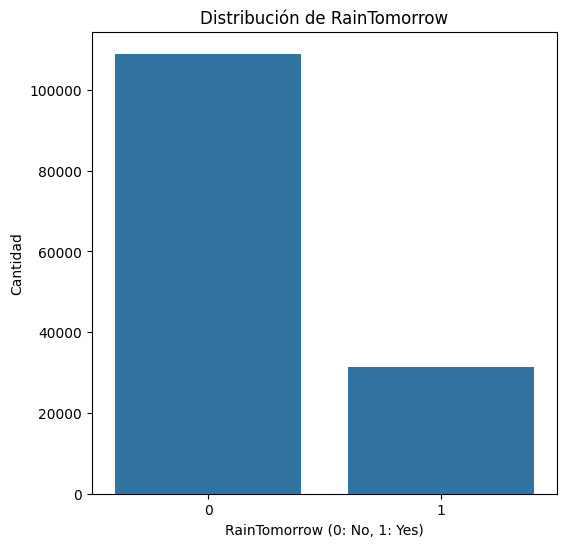

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(x=df['RainTomorrow'])
plt.title('Distribución de RainTomorrow')
plt.xlabel('RainTomorrow (0: No, 1: Yes)')
plt.ylabel('Cantidad')
plt.show()

Podemos observar que hay un claro desbalanceo de los datos, ya que la cantidad de registros con "No" es mayor a la cantidad de registros con "Yes".

Creemos que se hace esta pregunta para analizar cuestiones que puedan surgir a futuro en nuestro modelo y cómo esto lo afecta.

# División del conjunto de datos, Train y Test

In [34]:
# Definir las variables predictoras y la variable objetivo
X = df.drop(columns=['RainTomorrow'], axis=1)  # no usamos la columna objetivo
y = df['RainTomorrow']

# Dividir el conjunto en entrenamiento y prueba (sin imputar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reporte rápido
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))

Tamaño entrenamiento: (112318, 22)
Tamaño prueba: (28080, 22)
Distribución en y_train:
RainTomorrow
0    0.776082
1    0.223918
Name: proportion, dtype: float64

Distribución en y_test:
RainTomorrow
0    0.776104
1    0.223896
Name: proportion, dtype: float64


# Imputación de valores faltantes


- En base al comportamiento de las variables numéricas, decidimos imputar los valores faltantes de la siguiente manera:
  - Media: a las variables que muestran una distribución simétrica y normal
  - Mediana: es más robusta para las variables que tienen una distribución sesgada o con valores atípicos
  - KNN: a las variables que tienen distribuciones multimodales

- Para las variables categóricas, utilizaremos otro enfoque para imputar los valores faltantes, como la moda de las variables (la categoría más frecuente en cada columna).

In [35]:
def imputar_por_region(df, cols_media, cols_mediana, cols_knn):
    df_imputed = df.copy()

    # Media por región
    for col in cols_media:
        df_imputed[col] = df_imputed[col].fillna(
            df_imputed.groupby('Region')[col].transform('mean')
        )

    # Mediana por región
    for col in cols_mediana:
        df_imputed[col] = df_imputed[col].fillna(
            df_imputed.groupby('Region')[col].transform('median')
        )

    # KNN por región
    for region in df_imputed['Region'].unique():
        df_region = df_imputed[df_imputed['Region'] == region]
        imputador = KNNImputer(n_neighbors=5)
        imputadas = imputador.fit_transform(df_region[cols_knn])
        df_imputed.loc[df_region.index, cols_knn] = imputadas

    return df_imputed

In [36]:
# Columnas por tipo de imputación
cols_media = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm']
cols_mediana = ['Rainfall', 'Evaporation', 'Humidity9am', 'Humidity3pm',
                'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
cols_knn = ['Cloud9am', 'Cloud3pm', 'Sunshine']

In [37]:
# Aplicar imputación por separado en cada conjunto
X_train_imputed = imputar_por_region(X_train, cols_media, cols_mediana, cols_knn)
X_test_imputed = imputar_por_region(X_test, cols_media, cols_mediana, cols_knn)

In [38]:
# Imputar variables categóricas con la moda por región usando solo X_train
cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    # Obtener la moda por región en el set de train
    moda_por_region = X_train.groupby('Region')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

    # Imputar X_train
    X_train_imputed[col] = X_train_imputed.apply(
        lambda row: row[col] if pd.notnull(row[col]) else moda_por_region.loc[row['Region']],
        axis=1
    )

    # Imputar X_test usando moda de X_train
    X_test_imputed[col] = X_test_imputed.apply(
        lambda row: row[col] if pd.notnull(row[col]) else moda_por_region.loc[row['Region']],
        axis=1
    )

In [39]:
print("\nNulos restantes en X_train_imputed:", X_train_imputed.isnull().sum().sum())
print("Nulos restantes en X_test_imputed:", X_test_imputed.isnull().sum().sum())


Nulos restantes en X_train_imputed: 0
Nulos restantes en X_test_imputed: 0


# Codificación de variables categóricas

In [40]:
# Agrupaciones simplificadas de direcciones de viento
direccion_viento = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}
mapa_direcciones = {v: k for k, lista in direccion_viento.items() for v in lista}

# Columnas a transformar
columnas_viento = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
columnas_dummies = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season']

In [41]:
def procesar_X_fit(df, columnas_viento, columnas_dummies):
    df = df.copy()

    # Agrupar direcciones de viento
    for col in columnas_viento:
        df[col] = df[col].map(mapa_direcciones)

    # One-hot encoding y guardar columnas creadas
    df_dummies = pd.get_dummies(df, columns=columnas_dummies, drop_first=False)
    dummy_cols = df_dummies.columns.difference(df.columns).tolist()

    # Convertir a 0/1
    df_dummies.replace({True: 1, False: 0}, inplace=True)
    df_dummies.infer_objects(copy=False)

    return df_dummies, dummy_cols

def procesar_X_transform(df, columnas_viento, columnas_dummies, dummy_cols_train):
    df = df.copy()

    # Agrupar direcciones de viento
    for col in columnas_viento:
        df[col] = df[col].map(mapa_direcciones)

    # One-hot encoding
    df_dummies = pd.get_dummies(df, columns=columnas_dummies, drop_first=False)

    # Asegurar que tenga las mismas columnas que el train
    for col in dummy_cols_train:
        if col not in df_dummies.columns:
            df_dummies[col] = 0  # agregar columna faltante

    # Reordenar columnas para que coincidan
    df_dummies = df_dummies.reindex(columns=sorted(dummy_cols_train +
                        [col for col in df.columns if col not in columnas_dummies]), fill_value=0)

    # Convertir booleanos
    df_dummies.replace({True: 1, False: 0}, inplace=True)
    df_dummies.infer_objects(copy=False)

    return df_dummies

In [42]:
# Fit-transform en entrenamiento
X_train_processed, dummy_cols = procesar_X_fit(
    X_train_imputed, columnas_viento, columnas_dummies
)

# Transform en test con mismas columnas
X_test_processed = procesar_X_transform(
    X_test_imputed, columnas_viento, columnas_dummies, dummy_cols
)

In [43]:
X_train_processed.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_S,WindDir9am_W,WindDir3pm_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,Season_Invierno,Season_Otoño,Season_Primavera,Season_Verano
21414,13.9,19.7,0.0,4.6,10.700000,31.0,13.0,20.0,59.0,55.0,...,0,1,0,0,1,0,0,0,1,0
590,6.2,10.0,21.4,3.9,2.220000,57.0,24.0,19.0,82.0,91.0,...,0,0,0,1,0,0,1,0,0,0
79524,8.7,11.9,8.4,1.0,0.000000,37.0,13.0,15.0,100.0,100.0,...,1,0,0,0,1,0,1,0,0,0
104169,10.8,25.2,0.1,4.1,11.000000,30.0,15.0,17.0,64.0,42.0,...,0,0,0,0,0,1,0,0,1,0
5385,2.7,20.1,0.0,4.8,7.540887,20.0,9.0,4.0,69.0,37.0,...,1,0,0,1,0,0,0,0,1,0


In [44]:
X_test_processed.head()

,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,RainToday,...,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindGustDir_E,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindGustSpeed,WindSpeed3pm,WindSpeed9am
78429,7.00000,3.000000,11.8,30.0,57.0,32.8,17.0,1021.100000,1022.400000,0,...,0,0,0,0,1,0,0,39.0,22.0,9.0
86251,4.00000,4.000000,7.0,64.0,64.0,28.9,19.1,1014.600000,1018.200000,1,...,1,0,0,0,1,0,0,33.0,13.0,7.0
70801,8.00000,8.000000,9.0,39.0,66.0,28.7,18.1,1008.300000,1010.700000,0,...,0,1,0,0,0,1,0,28.0,11.0,19.0
24206,4.42029,4.344719,4.8,62.0,93.0,22.4,17.2,1015.573368,1018.089671,1,...,0,1,0,0,0,1,0,33.0,17.0,9.0
25777,4.42029,4.344719,4.8,35.0,92.0,28.3,8.3,1015.573368,1018.089671,0,...,1,0,0,0,0,1,0,17.0,2.0,2.0


# Matriz de correlación (numérica)

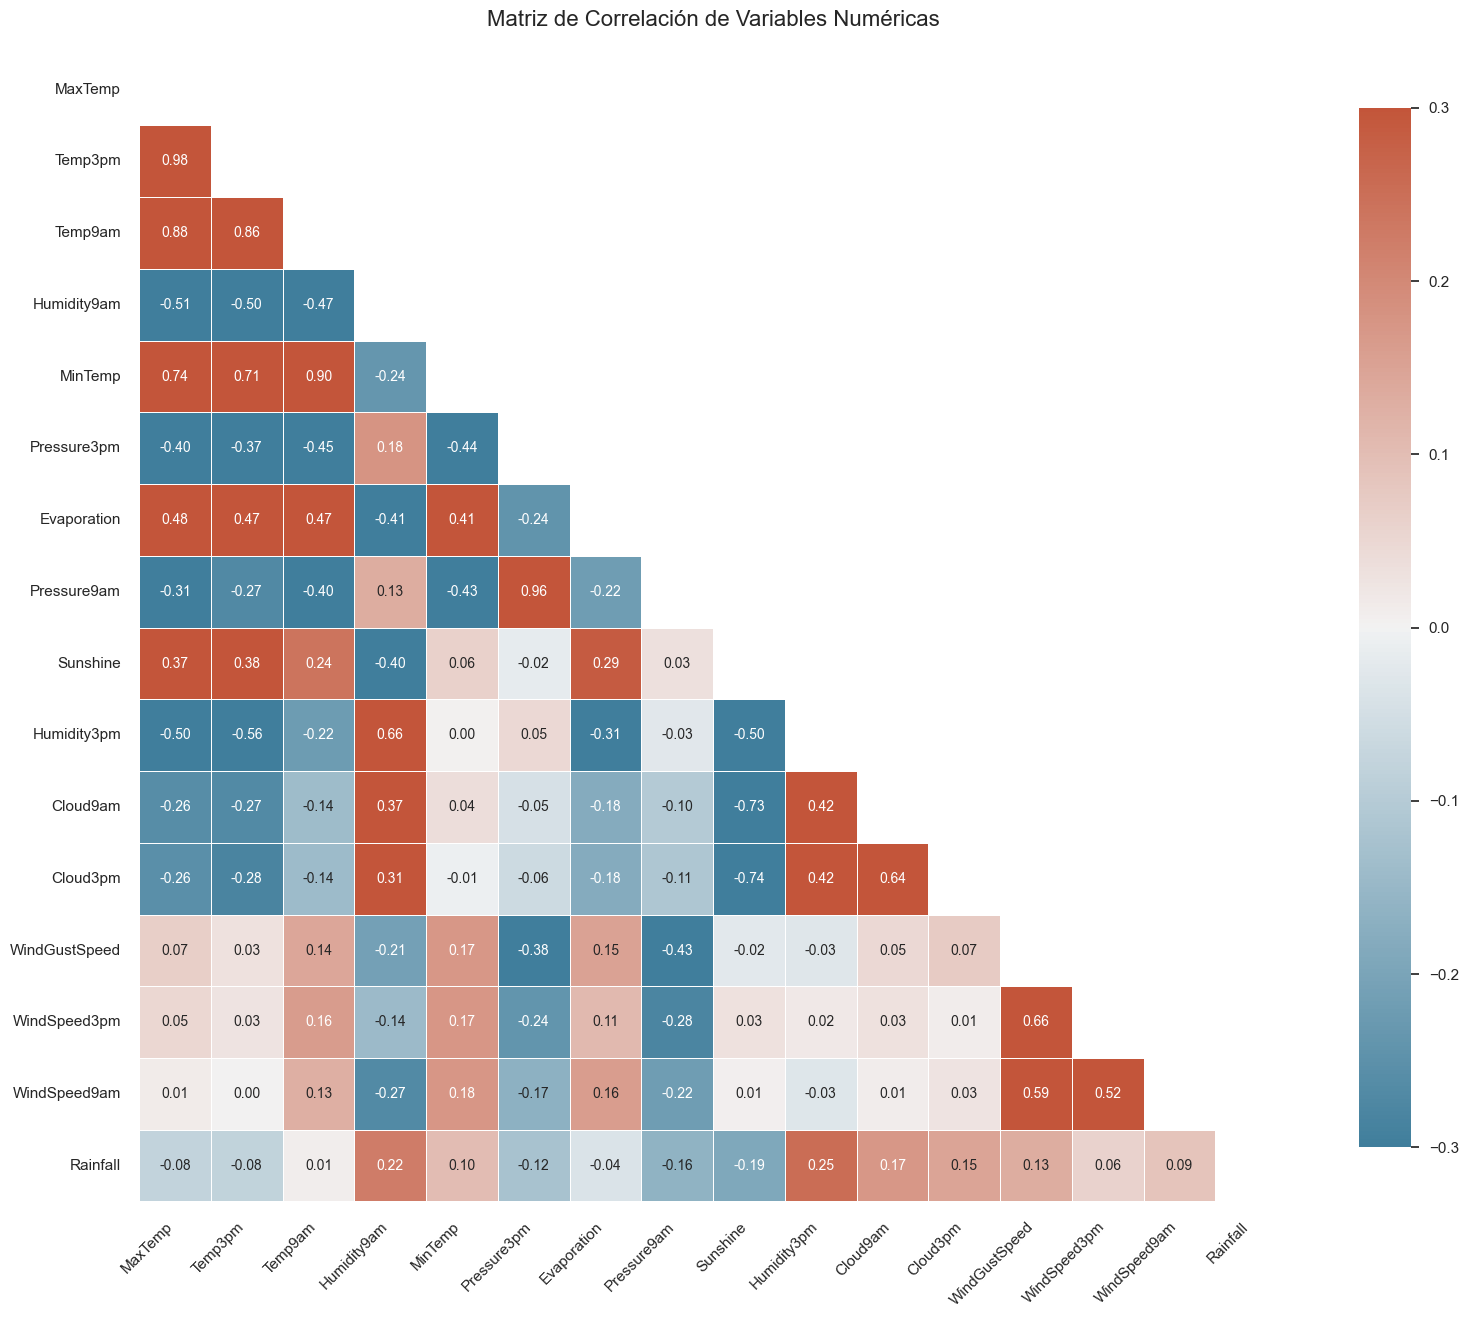

In [45]:
# Definir las columnas numéricas relevantes
numeric_cols = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
    'Temp9am', 'Temp3pm'
]

# Calcular la matriz de correlación
corr_matrix = X_train_processed[numeric_cols].corr()

# Ordenar las variables por su correlación total (opcional, mejora visual)
corr_matrix = corr_matrix.loc[
    corr_matrix.abs().sum().sort_values(ascending=False).index,
    corr_matrix.abs().sum().sort_values(ascending=False).index
]

# Crear la máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Tamaño de la figura
plt.figure(figsize=(16, 14))
sns.set_theme(style="white")

# Paleta de colores personalizada
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap con anotaciones
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

plt.title("Matriz de Correlación de Variables Numéricas", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Interpretación de la matriz de correlación

Correlaciones positivas:
- MaxTemp, Temp3pm y Temp9am están fuertemente correlacionadas entre sí, lo que indica que las temperaturas en diferentes momentos del día se mueven de manera muy similar.
- Pressure3pm y Pressure9am también presentan una correlación muy alta, apuntando que la presión atmosférica medida en la mañana y la tarde tiende a ser similar.
- Cloud9am y Cloud3pm están correlacionadas positivamente, lo que sugiere que la nubosidad tiende a mantenerse durante el día.

Correlaciones negativas:
- Humidity9am y Humidity3pm están negativamente correlacionadas con las temperaturas (MaxTemp, Temp3pm, Temp9am), lo que indica que cuando la temperatura es alta, la humedad suele ser baja, y viceversa.
- Cloud9am y Cloud3pm tienen correlaciones negativas con las temperaturas y con la humedad, mostrando que la nubosidad puede estar inversamente relacionada con algunos otros factores climáticos.

# Matriz de correlación (categórica)

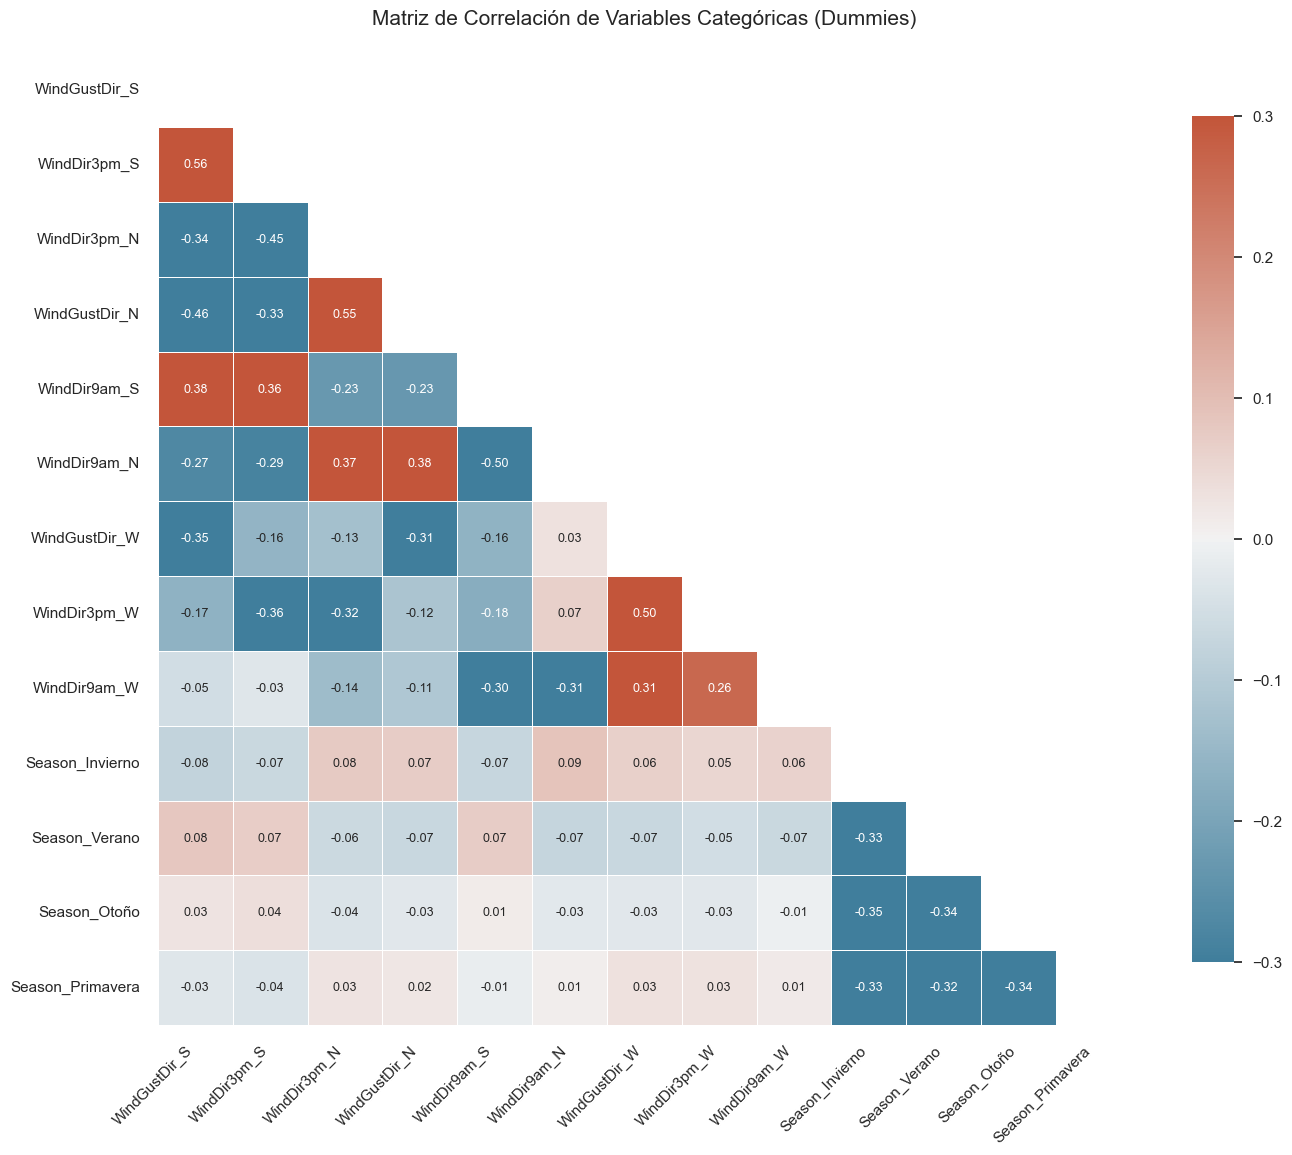

In [47]:
# Establecer estilo
sns.set_theme(style="white")

# Seleccionar variables categóricas dummy
categorical_dummies = [
    'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
    'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
    'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
    'Season_Invierno', 'Season_Otoño', 'Season_Primavera',
    'Season_Verano'
]

# Calcular matriz de correlación
corr_matrix = X_train_processed[categorical_dummies].corr()

# Reordenar columnas para visualización clara
corr_matrix = corr_matrix.loc[
    corr_matrix.abs().sum().sort_values(ascending=False).index,
    corr_matrix.abs().sum().sort_values(ascending=False).index
]

# Crear máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Tamaño y figura
plt.figure(figsize=(14, 12))

# Colormap personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9}
)

plt.title("Matriz de Correlación de Variables Categóricas (Dummies)", fontsize=15, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Interpretación de la matriz categórica

Hay correlaciones moderadas entre algunas direcciones de viento:
- WindGustDir_S y WindDir3pm_S: sugiere que cuando hay ráfagas del sur, es usual que la dirección del viento a las 3pm también sea sur.
- WindGustDir_N y WindDir3pm_N: tiene un patrón similar pero en dirección norte.

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [48]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [49]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
X_train_processed[columns_to_standardize] = scaler.fit_transform(X_train_processed[columns_to_standardize])

In [50]:
X_train_processed

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_S,WindDir9am_W,WindDir3pm_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,Season_Invierno,Season_Otoño,Season_Primavera,Season_Verano
21414,0.268654,-0.494312,-0.281224,-0.129293,1.023297,-0.671760,-0.113625,0.153564,-0.518974,0.170842,...,0,1,0,0,1,0,0,0,1,0
590,-0.934969,-1.857097,2.324052,-0.346125,-1.624015,1.298921,1.128967,0.039482,0.691830,1.918660,...,0,0,0,1,0,0,1,0,0,0
79524,-0.544182,-1.590160,0.741408,-1.244429,-2.317062,-0.216988,-0.113625,-0.416848,1.639416,2.355615,...,1,0,0,0,1,0,1,0,0,0
104169,-0.215922,0.278401,-0.269050,-0.284173,1.116952,-0.747556,0.112301,-0.188683,-0.255756,-0.460315,...,0,0,0,0,0,1,0,0,1,0
5385,-1.482070,-0.438115,-0.281224,-0.067341,0.037076,-1.505510,-0.565476,-1.671756,0.007463,-0.703067,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33578,0.878281,0.629634,-0.281224,-0.067341,-0.568837,-0.216988,0.112301,1.066224,-0.466330,0.073741,...,0,0,1,0,0,0,0,0,0,1
131774,0.346811,-0.086882,-0.281224,0.242419,-0.038125,-0.671760,-0.339550,0.039482,0.533899,0.607797,...,0,0,1,0,0,0,0,0,0,1
48137,0.409337,0.882522,0.863150,-0.346125,-1.624015,-0.747556,-0.791402,-1.101343,0.270681,-0.266113,...,1,0,0,1,0,0,0,0,0,1
66528,-0.888075,-1.365371,-0.281224,-0.934669,-1.068329,1.071534,-0.565476,1.294389,0.533899,0.899100,...,1,0,0,0,1,0,1,0,0,0


## Estandarización de Test

In [51]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
X_test_processed[columns_to_standardize] = scaler.transform(X_test_processed[columns_to_standardize])

In [52]:
X_test_processed

,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,RainToday,...,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindGustDir_E,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindGustSpeed,WindSpeed3pm,WindSpeed9am
78429,1.110476,-0.604256,2.100980,-1.042921,-0.624261,1.346149,0.753230,0.861656,0.693525,0,...,0,0,0,0,1,0,0,-0.065397,0.381729,-0.565476
86251,-0.227442,-0.183124,0.614131,0.607797,-0.255756,0.798226,1.081490,-0.104648,0.075349,1,...,1,0,0,0,1,0,0,-0.520170,-0.645013,-0.791402
70801,1.556449,1.501404,1.233651,-0.605966,-0.150468,0.770127,0.925176,-1.041219,-1.028537,0,...,0,1,0,0,0,1,0,-0.899147,-0.873178,0.564152
24206,-0.040004,-0.037952,-0.067341,0.510695,1.270911,-0.114981,0.784492,0.040055,0.059110,1,...,0,1,0,0,0,1,0,-0.520170,-0.188683,-0.565476
25777,-0.040004,-0.037952,-0.067341,-0.800168,1.218267,0.713930,-0.606708,0.040055,0.059110,0,...,1,0,0,0,0,1,0,-1.732896,-1.899921,-1.356216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145052,-0.196056,-0.192872,0.490227,-1.722628,-0.518974,0.643683,-0.747391,0.564332,0.693525,0,...,0,0,0,0,1,0,0,-1.505510,-1.329508,-0.904365
124834,-0.291334,-0.204442,-0.191245,-0.557416,-0.782192,0.236253,0.596915,0.092222,0.056215,0,...,0,0,1,0,0,0,1,2.587443,2.092967,2.145632
122544,1.556449,0.659140,1.357555,0.559246,-0.518974,0.727979,0.972070,-1.056085,-1.249314,0,...,1,0,0,0,0,1,0,-0.899147,-0.873178,-0.565476
31913,-1.565361,-0.183124,0.180467,0.122291,-0.782192,0.222203,0.972070,0.192676,0.163660,0,...,0,0,0,1,0,0,0,-0.747556,0.039482,-0.791402


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# Balanceo de datos


Realizamos un balanceo de datos en el conjunto de entrenamiento utilizando la técnica SMOTETomek.

In [53]:
# Antes de aplicar SMOTETomek, volver a comprobar si hay valores NaN
print("Valores NaN en X_train_processed antes de SMOTETomek:")
print(X_train_processed.isnull().sum())

print("\nValores NaN en y_train antes de SMOTETomek:")
print(y_train.isnull().sum())

Valores NaN en X_train_processed antes de SMOTETomek:
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
Region              0
RainToday           0
WindGustDir_E       0
WindGustDir_N       0
WindGustDir_S       0
WindGustDir_W       0
WindDir9am_E        0
WindDir9am_N        0
WindDir9am_S        0
WindDir9am_W        0
WindDir3pm_E        0
WindDir3pm_N        0
WindDir3pm_S        0
WindDir3pm_W        0
Season_Invierno     0
Season_Otoño        0
Season_Primavera    0
Season_Verano       0
dtype: int64

Valores NaN en y_train antes de SMOTETomek:
0


In [54]:
# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

# Asegurarse de que y_train no sea un DataFrame
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

# Reemplazar directamente X_train y y_train con los datos balanceados
X_train_processed, y_train = smote_tomek.fit_resample(X_train_processed, y_train)

# El conjunto de prueba se mantiene sin cambios
X_test_processed, y_test = X_test_processed, y_test  # No hacemos nada con X_test ni y_test

# Verificar las formas de los datos balanceados
print("Tamaño de X_train después de SMOTETomek:", X_train_processed.shape)
print("Tamaño de y_train después de SMOTETomek:", y_train.shape)
print("Tamaño de X_test (sin cambios):", X_test_processed.shape)
print("Tamaño de y_test (sin cambios):", y_test.shape)

Tamaño de X_train después de SMOTETomek: (173686, 34)
Tamaño de y_train después de SMOTETomek: (173686,)
Tamaño de X_test (sin cambios): (28080, 34)
Tamaño de y_test (sin cambios): (28080,)


In [55]:
print("X_train_balanced shape:", X_train_processed.shape)
print("y_train_encoded shape:", y_train.shape)

X_train_balanced shape: (173686, 34)
y_train_encoded shape: (173686,)


In [56]:
print("\nDistribución después del balanceo:")
print(pd.Series(y_train).value_counts(normalize=True))


Distribución después del balanceo:
RainTomorrow
0    0.5
1    0.5
Name: proportion, dtype: float64


El método **SMOTETomek** combina **SMOTE**, que genera datos sintéticos para la clase minoritaria, con **Tomek Links**, que elimina datos redundantes de la clase mayoritaria. Esto balancea los datos mejorando la representación de la clase minoritaria y limpiando el ruido en la mayoritaria.

Se justifica su uso porque:
1. **Maneja desbalance de clases**: Evita que el modelo se sesgue hacia la clase mayoritaria.
2. **Mejora el aprendizaje**: Permite límites de decisión más claros y mejor desempeño en métricas como sensibilidad y F1-Score.
3. **Generaliza bien**: Los datos balanceados son más representativos para el entrenamiento.

El conjunto de prueba permanece sin cambios para evaluar el modelo con la distribución original, asegurando resultados realistas.

# Regresión logística

In [57]:
# Modelo con regularización L2 (por defecto)
model_l2 = LogisticRegression()
model_l2.fit(X_train_processed, y_train)

# Reordenar columnas por si acaso
X_test_processed = X_test_processed[X_train_processed.columns]

y_pred_l2 = model_l2.predict(X_test_processed)
y_proba_l2 = model_l2.predict_proba(X_test_processed)[:, 1]
f1_l2 = f1_score(y_test, y_pred_l2)

print(f"F1-score con regularización L2: {f1_l2:.2f}")

F1-score con regularización L2: 0.62


In [58]:
# Modelo sin regularización

model_none = LogisticRegression(penalty=None, solver='saga', max_iter=2000)
model_none.fit(X_train_processed, y_train)

y_pred_none = model_none.predict(X_test_processed)
y_proba_none = model_none.predict_proba(X_test_processed)[:, 1]
f1_none = f1_score(y_test, y_pred_none)

print(f"F1-score sin regularización: {f1_none:.2f}")

F1-score sin regularización: 0.62


In [59]:
# Comparar y elegir mejor modelo según F1-score
if f1_none > f1_l2:
    print("El modelo sin regularización tiene mejor F1-score")
    best_model = model_none
    y_pred = y_pred_none
    y_proba = y_proba_none
else:
    print("El modelo con regularización L2 tiene mejor F1-score")
    best_model = model_l2
    y_pred = y_pred_l2
    y_proba = y_proba_l2

El modelo con regularización L2 tiene mejor F1-score


In [60]:
# Métricas finales del mejor modelo
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMétricas del mejor modelo de Regresión Logística:")
print(f"Accuracy:  {accuracy:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     21793
           1       0.58      0.67      0.62      6287

    accuracy                           0.82     28080
   macro avg       0.74      0.77      0.75     28080
weighted avg       0.83      0.82      0.82     28080


Métricas del mejor modelo de Regresión Logística:
Accuracy:  0.82
ROC AUC:   0.86


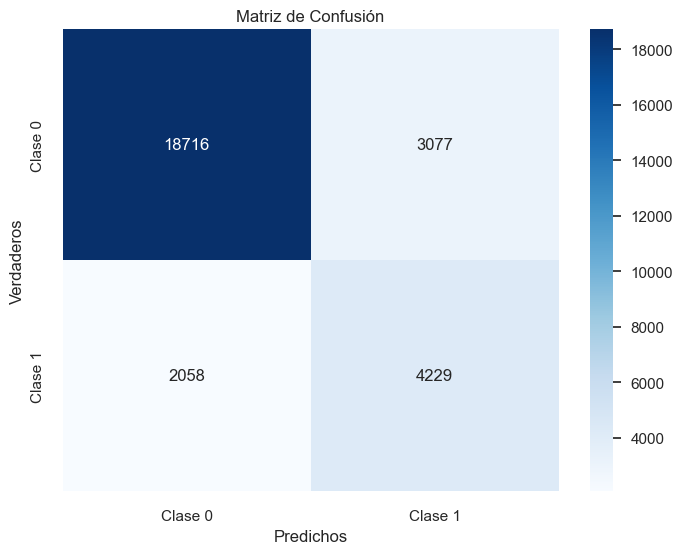

In [61]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz de Confusión')
plt.show()

A partir de la matriz de confusión, podemos observar que el modelo tiende a predecir una mayor cantidad de falsos positivos (3989) que de falsos negativos (1858).

### Cálculo de la curva ROC

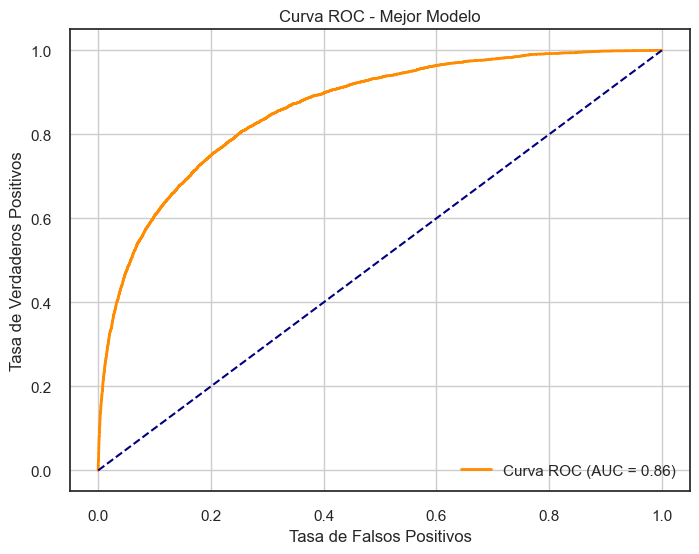

In [62]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Mejor Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Por defecto, el modelo de regresión logística utiliza un umbral de 0.5. En este caso, consideramos que ese valor no sería óptimo ya que nuestro dataset está desbalanceado. Para evitar falsos negativos, sería mejor implementar un umbral más bajo.

Para encontrar el mejor umbral, trataremos de maximizar el F1-score para cada umbral.

In [63]:
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Mejor umbral según F1-score: {best_thresh:.2f} (F1 = {f1_scores[best_idx]:.2f})")

Mejor umbral según F1-score: 0.52 (F1 = 0.62)


Un umbral de 0.59 mejora el F1-score a 0.61, lo cual sugiere un mejor equilibrio entre precisión y recall, y prioriza evitar falsos negativos

# Modelo base

In [64]:
# Modelo base
model_base = DummyClassifier(strategy='stratified', random_state=42)
model_base.fit(X_train_processed, y_train)

# Predicciones
y_pred_base = model_base.predict(X_test_processed)
y_proba_base = model_base.predict_proba(X_test_processed)[:, 1]

### Métricas de evaluación

In [65]:
accuracy = accuracy_score(y_test, y_pred_base)
roc_auc = roc_auc_score(y_test, y_proba_base)
f1_dummy = f1_score(y_test, y_pred_base)

# Reporte
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_base))
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1-score: {f1_dummy:.2f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.50      0.61     21793
           1       0.23      0.51      0.31      6287

    accuracy                           0.50     28080
   macro avg       0.50      0.51      0.46     28080
weighted avg       0.66      0.50      0.55     28080

ROC AUC: 0.51
F1-score: 0.31


### Matriz de Confusión + Análisis de falsos positivos y negativos

- Falsos negativos (FN) son más graves si no queremos perder casos verdaderamente positivos (en nuestro caso, predecir que no llueve cuando en realidad sí llueve).
- Falsos positivos (FP) pueden implicar revisar manualmente casos que en realidad no lo necesitaban.

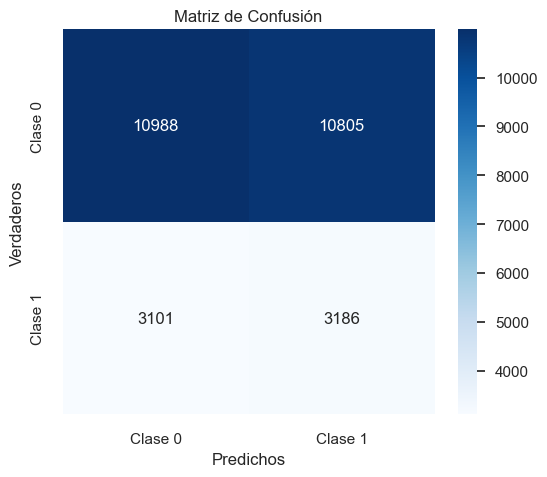

Falsos Positivos: 10805 - El modelo predijo '1' cuando era '0'
Falsos Negativos: 3101 - El modelo predijo '0' cuando era '1'


In [66]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz de Confusión')
plt.show()

# Análisis básico
tn, fp, fn, tp = cm.ravel()
print(f"Falsos Positivos: {fp} - El modelo predijo '1' cuando era '0'")
print(f"Falsos Negativos: {fn} - El modelo predijo '0' cuando era '1'")

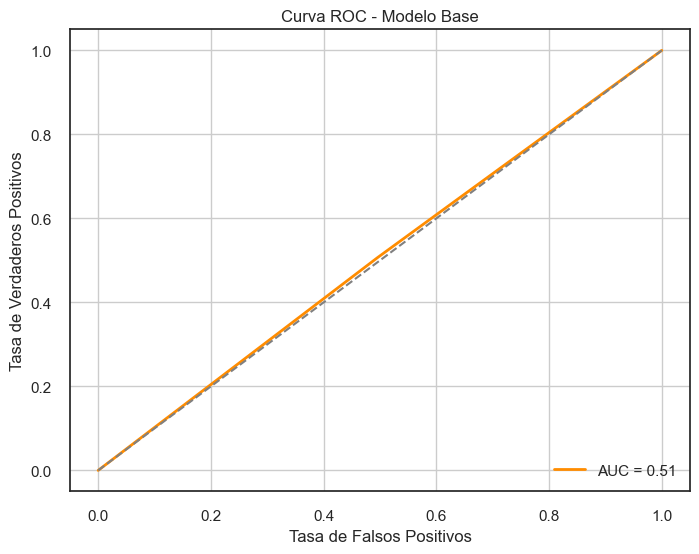

In [67]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base)
roc_auc = roc_auc_score(y_test, y_proba_base)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo Base')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [68]:
# Encontrar el mejor umbral (máximo F1)
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = [f1_score(y_test, (y_proba_base >= t).astype(int)) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral por F1-score: {best_thresh:.2f} (F1 = {best_f1:.2f})")

Mejor umbral por F1-score: 0.00 (F1 = 0.37)


In [69]:
# Comparación de modelos

def evaluar_modelo(nombre, y_true, y_pred, y_proba):
    """
    Función para evaluar un modelo.
    :param nombre: Nombre del modelo.
    :param y_true: Etiquetas verdaderas.
    :param y_pred: Etiquetas predichas.
    :param y_proba: Probabilidades de pertenencia a la clase positiva.
    """
    print(f"\n=== {nombre} ===")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC  :  {roc_auc_score(y_true, y_proba):.2f}")

evaluar_modelo("Modelo Base", y_test, y_pred_base, y_proba_base)
evaluar_modelo("Regresión Logística", y_test, y_pred, y_proba)


=== Modelo Base ===
              precision    recall  f1-score   support

           0       0.78      0.50      0.61     21793
           1       0.23      0.51      0.31      6287

    accuracy                           0.50     28080
   macro avg       0.50      0.51      0.46     28080
weighted avg       0.66      0.50      0.55     28080

ROC AUC  :  0.51

=== Regresión Logística ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     21793
           1       0.58      0.67      0.62      6287

    accuracy                           0.82     28080
   macro avg       0.74      0.77      0.75     28080
weighted avg       0.83      0.82      0.82     28080

ROC AUC  :  0.86


El modelo base alcanza un accuracy del 50% y un ROC AUC de 0.51, indicando que clasifica casi al azar, con un bajo recall para la clase mayoritaria y bajo desempeño general.

En cambio, la Regresión Logística aumenta el accuracy al 79%, mejora el recall de la clase positiva (70%) y logra un ROC AUC de 0.85, lo que indica una muy buena capacidad de discriminación entre clases.

Concluimos que la Regresión Logística supera ampliamente al modelo base, siendo mucho más efectiva para identificar correctamente tanto positivos como negativos

# Búsqueda de hiperparámetros


### Random search

In [70]:
param_dist = {
    'C': loguniform(1e-3, 1e3),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 250, 500],
    'class_weight': ['balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=1,  
    random_state=42,
    verbose=1
)

random_search.fit(X_train_processed, y_train)

print("Mejor resultado - RandomizedSearch:")
print(random_search.best_params_)
print(f"F1 score: {random_search.best_score_:.2f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor resultado - RandomizedSearch:
{'C': 0.10051981180656774, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
F1 score: 0.83


In [71]:
random_model = random_search.best_estimator_

y_pred_random = random_model.predict(X_test_processed)
y_proba_random = random_model.predict_proba(X_test_processed)[:, 1]

print("\n Reporte del mejor modelo (Random Search)")
print(classification_report(y_test, y_pred_random))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_random):.2f}")


 Reporte del mejor modelo (Random Search)
              precision    recall  f1-score   support

           0       0.90      0.85      0.88     21793
           1       0.57      0.68      0.62      6287

    accuracy                           0.82     28080
   macro avg       0.74      0.77      0.75     28080
weighted avg       0.83      0.82      0.82     28080

ROC AUC: 0.86


In [72]:
f1_random_logistic = f1_score(y_test, y_pred_random)
print(f"F1-score del mejor modelo (Random Search): {f1_random_logistic:.2f}")

F1-score del mejor modelo (Random Search): 0.62


# SHAP

### Local

In [73]:
feature_names=X_train_processed.columns.values

In [136]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model_none, X_train_processed)

# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_processed)

In [129]:
shap_values.shape

(28080, 34)

In [123]:
len(y_test),len(feature_names)

(28080, 34)

In [124]:
index=2

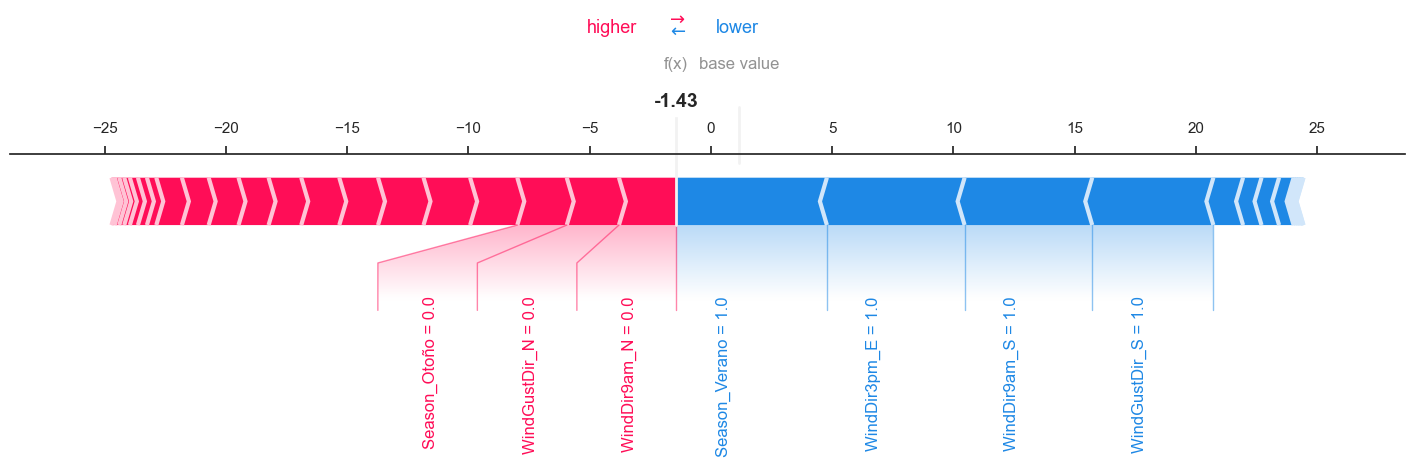

In [137]:
shap.force_plot(explainer.expected_value,
                shap_values[index],
                X_test_processed.iloc[index],
                figsize=(18, 4),
                matplotlib=True,
                text_rotation=90)

***Variables que aumentan la predicción (rojo):***
- **Pressure3pm:** Un bajo valor de presión atmosférica suele estar asociado a condiciones menos estables
- **Sunshine:** Muy poca cantidad de sol en el día suele estar asociado con mayor probabilidad de luvia
- **Cloud3pm:** Una alta cobertura de nubes a las 3pm suele indicar condiciones inestables, reforzando la probabilidad de lluvia


***Variables que disminuyen la predicción (azul):***
- **Humidity3pm:** Un bajo nivel de humedad a las 3pm reduce la probabilidad de lluvia
- **WindGustSpeed:** Las ráfagas de viento algo intensas podrían indicar condiciones más secas
- **WindDir9pm_S y WindGustDir_S:** La dirección del viento por la mañana desde el sur y durante el día está asociado a condiciones de poca lluvia

A pesar de que varias variables intentan disminuir la probabilidad de lluvia, el modelo aún asigna una predicción moderadamente cercana a la clase 1 (lluvia) con f(x) = -0.86, indicando que está inclinado hacia no lluvia, pero con influencia importante de condiciones típicas para lluvia (nubosidad, poca luz solar, baja presión atmosférica)

In [131]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)

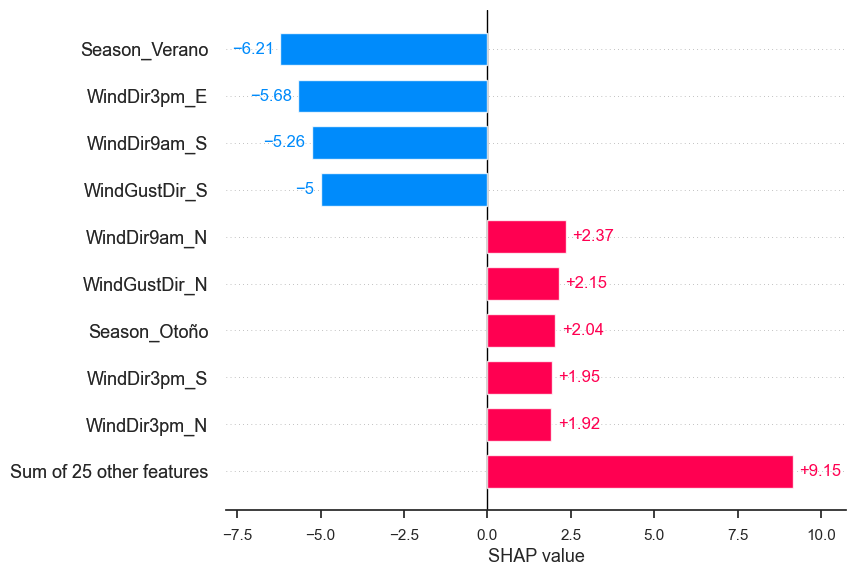

In [132]:
shap.plots.bar(explanation)

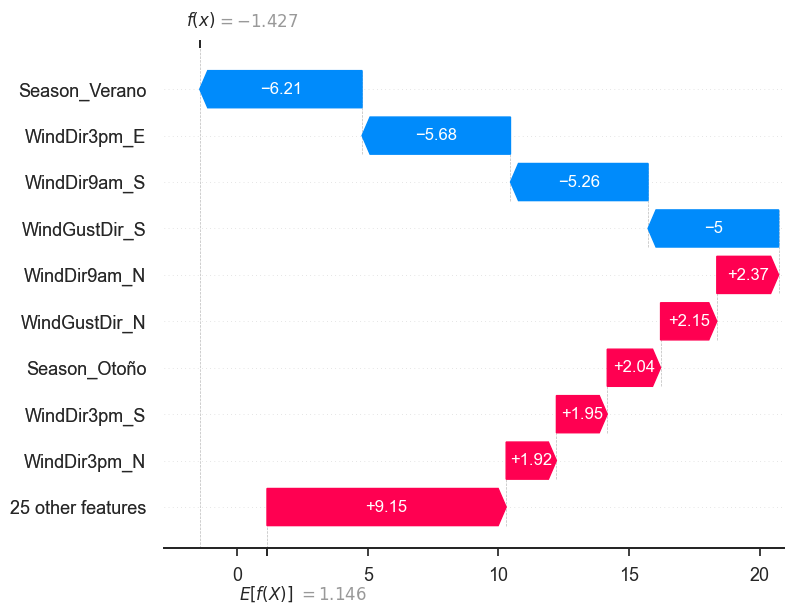

In [133]:
shap.plots.waterfall(explanation)

Variables que reducen la probabilidad de lluvia (azul):
- Humidity3pm (−0.92): Si la humedad a las 3PM es baja, el modelo predice menos lluvia.
- WindGustSpeed (−0.84): Ráfagas de viento más intensas tienden a asociarse con menos lluvia.
- WindDir9am_S (−0.74): El viento desde el sur a las 9am se asocia con condiciones más secas.
- WindGustDir_S (−0.50): Similar a la anterior, pero para la dirección del viento con ráfagas.

Variables que aumentan la probabilidad de lluvia (rojo):
- Pressure3pm (+0.60): Una presión más baja por la tarde se asocia con condiciones de lluvia.
- Sunshine (+0.54): Los días con menor cantidad de luz solar aumentan la predicción de lluvia.
- Cloud3pm (+0.42): Una mayor nubosidad a las 3pm es un fuerte indicador de lluvia.
- WindGustDir_N y WindDir9am_N: El viento desde el norte podría estar vinculado a masas de aire más húmedas.

A partir de estos gráficos, podemos concluir que:
- La variable Humidity3pm es la que tiene un mayor impacto negativo, reduciendo el valor predicho. Esto sugiere que cuando la humedad a las 3pm es baja, el modelo predice menos lluvia
- Pressure3pm es la variable que más contribuyó positivamente, aumentando la predicción.

### Global

In [82]:
explanation_global = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_processed)

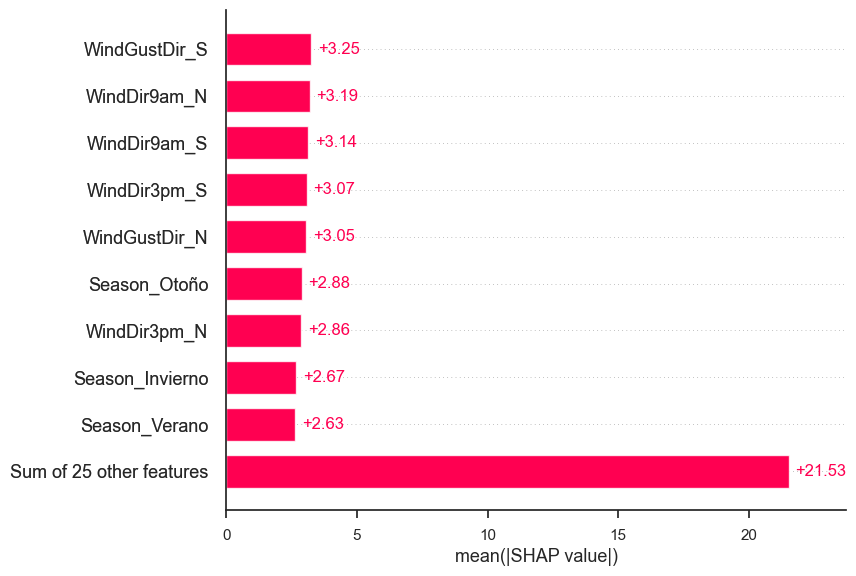

In [83]:
shap.plots.bar(explanation_global)

Con este gráfico, podemos observar la importancia promedio de cada variable en odas las predicciones del modelo. Siendo las siguientes las más destacadas:
- Humidity3pm: es la más influyente, indica que la humedad en la tarde tiene un gran impacto en la predicción
- WindGustSpeed y Pressure3pm: también aportan significativamente al resultado, pero en menor medida que la anterior

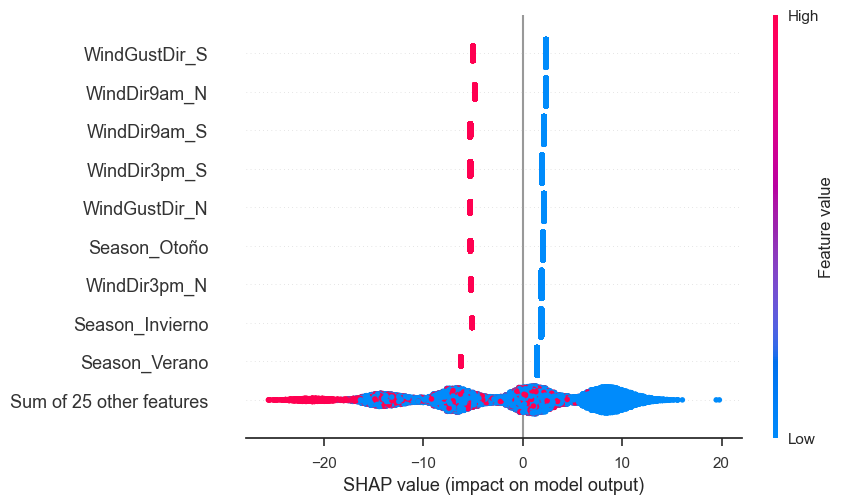

In [84]:
shap.plots.beeswarm(explanation_global)

Este gráfico muestra qué tan importantes son las variables y cómo afectan el resultado según sus valores.

Observamos los valores altos (en rojo) y los valores bajos (en azul) de cada variable, en donde cada punto representa una observación. También verifica los análisis obtenidos de gráficos anteriores.

Podemos decir que el modelo está principalmente influenciado por las variables de humedad, viento y presión.

# Implementación de AutoML

Proceso de AutoML con PyCaret para seleccionar el mejor modelo de clasificación basado en varias métricas de rendimiento.

**Propósito del Código**
- Automatizar el proceso de creación y evaluación de modelos de clasificación.
- Facilitar la elección del mejor modelo de acuerdo a métricas como precisión, F1 Score, y Recall.

Copio el DataFrame con los datos de entrada.


In [85]:
data_automl  = df.copy()

Configura el entorno para un problema de clasificación y define la variable objetivo.

- setup() es la función central de PyCaret para inicializar el entorno y configurar el modelo.

In [86]:
setup(data=data_automl,
      target='RainTomorrow',
      train_size=0.8,
      fix_imbalance=True,
      session_id=123,
      normalize=True)

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(140398, 23)"
4,Transformed data shape,"(202416, 71)"
5,Transformed train set shape,"(174336, 71)"
6,Transformed test set shape,"(28080, 71)"
7,Numeric features,18
8,Categorical features,4
9,Rows with missing values,59.8%


#### Interpretación

- Transformaciones realizadas
  - Los datos se expandieron a 72 columnas por el procesamiento
  - Conjunto de entrenamiento: 174.336 filas, 72 columnas
  - Conjunto de prueba: 28.080 filas, 72 columnas
  - El número de filas aumentó porque se aplicó SMOTE para balancear la clase minoritaria
- Variables (features)
  - 23 variables numéricas
  - 3 variables categóricas
  - 59.8% de las filas tenían valores faltantes

- Preprocesamiento implementado
  - Imputación numérica: media
  - Imputación categórica: moda
  - Normalización: con z-score (media 0, desviación estándar 1)
  - Balanceo de clases: activado con SMOTE (fix_imbalance=True)

- Validación cruzada
  - Tipo de validación: StratifiedKFold con 10 folds

Evalúa automáticamente diferentes modelos de clasificación y selecciona el mejor según las métricas de rendimiento.

In [87]:
best_model = compare_models()
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8566,0.8881,0.5791,0.7251,0.6439,0.5555,0.5610,20.8980
lightgbm,Light Gradient Boosting Machine,0.8554,0.8874,0.5595,0.7316,0.6340,0.5459,0.5536,4.3990
et,Extra Trees Classifier,0.8553,0.8869,0.5433,0.7415,0.6271,0.5399,0.5500,19.0240
gbc,Gradient Boosting Classifier,0.8394,0.8691,0.6028,0.6532,0.6270,0.5248,0.5255,30.9790
ada,Ada Boost Classifier,0.8185,0.8462,0.6116,0.5918,0.6014,0.4840,0.4842,9.1140
ridge,Ridge Classifier,0.7917,0.8663,0.7608,0.5241,0.6206,0.4837,0.4997,3.8170
lda,Linear Discriminant Analysis,0.7917,0.8663,0.7608,0.5241,0.6206,0.4837,0.4997,3.7220
lr,Logistic Regression,0.7887,0.8671,0.7710,0.5190,0.6204,0.4816,0.4998,7.1300
dt,Decision Tree Classifier,0.7818,0.7006,0.5537,0.5118,0.5319,0.3899,0.3904,8.4240
svm,SVM - Linear Kernel,0.7806,0.8596,0.7679,0.5069,0.6105,0.4666,0.4863,4.6990


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [88]:
# Extraemos la tabla de resultados
results = pull()

# Nos quedamos con el F1-score del mejor modelo
f1_automl = results.loc[results.index[0], 'F1']  # el índice es 0 porque toma el F1 Score del modelo que aparece primero en el ranking
print(f"Mejor F1-score (AutoML): {f1_automl}")

Mejor F1-score (AutoML): 0.6439


In [89]:
from pycaret.classification import save_model

save_model(best_model, 'docker_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['MinTemp', 'MaxTemp', 'Rainfall',
                                              'Evaporation', 'Sunshine',
                                              'WindGustSpeed', 'WindSpeed9am',
                                              'WindSpeed3pm', 'Humidity9am',
                                              'Humidity3pm', 'Pressure9am',
                                              'Pressure3pm', 'Cloud9am',
                                              'Cloud3pm', 'Temp9am', 'Temp3pm',
                                              'Region', 'RainToday'],
                                     transformer=SimpleImp...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth

#### Comparación de modelos

- **XGBoost (Extreme Gradient Boosting):**
Fue el modelo con mejor desempeño general, con una Accuracy de 86.17%, un AUC de 0.8953, y un F1-Score de 0.6520. Logró el mejor balance entre Precision (0.7467) y Recall (0.5788), lo que lo convierte en una excelente opción para este problema de clasificación binaria.

- **LightGBM y Extra Trees:**
Ambos modelos presentan métricas competitivas. LightGBM obtuvo un Accuracy de 85.80% y un AUC de 0.8905, mientras que Extra Trees alcanzó 85.73% de Accuracy y un AUC de 0.8896. Aunque ligeramente inferiores a XGBoost, ofrecen buenos F1-Scores (0.6410 y 0.6362) y una relación razonable entre Precision y Recall

- **Random Forest:**
Tuvo un rendimiento similar al de LightGBM, con un Recall de 0.5895, superior al de XGBoost, aunque con una Precision menor (0.7198). Su F1-Score (0.6481) también lo hace un modelo robusto

- **Gradient Boosting Classifier (GBC):**
Tiene el Recall más alto entre los principales modelos (0.6245), aunque su Precision fue más baja (0.6375), con un F1-Score de 0.6309. Sin embargo, su tiempo de entrenamiento fue el más alto (147.5 segundos), lo que puede ser una limitación en ciertos casos

- **Modelos más simples:**

	- **Logistic Regression:** Obtuvo una Accuracy de 78.85% y un Recall alto (0.7718), pero 	sacrificando Precision (0.5186). Es útil en escenarios donde se prioriza detectar la 	mayor cantidad de positivos (minimizar falsos negativos)

	- **LDA y Ridge Classifier:** Mostraron resultados similares, con Accuracy alrededo del 79% y F1-Scores cerca de 0.62, lo cual es competitivo dado su bajo costo computacional

- **Modelos con menor rendimiento:**

	- **Naive Bayes y QDA** mostraron valores de Accuracy por debajo del 71%, y F1-Scores  entre 0.44 y 0.50, lo que sugiere una baja capacidad predictiva en este contexto

	- **Dummy Classifier** no identificó ningún caso positivo (F1 = 0), y Decision Tree 	obtuvo un AUC muy bajo (0.7054)


#### Conclusión

A partir de este análisis, podemos concluir que el modelo **XGBoost** se destaca como la mejor opción para nuestro problema, debido a su gran rendimiento general en todas las métricas importantes. Cabe destacar que otros modelos como Random Forest y LightGBM también ofrecen buenos resultados, pero XGBoost proporciona el mejor equilibrio entre precisión, recall y capacidad predictiva.

### Creación del df de test para MLOPS

In [91]:
# Cargar los datos originales del entrenamiento para recrear el entorno
df_train = df.copy()  # Usar rl archivo original 
clf1 = setup(data=df_train, target='RainTomorrow', train_size=0.8, fix_imbalance=True, normalize=True, session_id=123)

# Obtener las columnas esperadas
expected_columns = get_config('X_train').columns.tolist()

# Cargar datos de test
df_test = pd.read_csv("TEST_preparado.csv")

# Identificar columnas faltantes y sobrantes
faltantes = [col for col in expected_columns if col not in df_test.columns]
sobrantes = [col for col in df_test.columns if col not in expected_columns]

print("Columnas faltantes:", faltantes)
print("Columnas sobrantes:", sobrantes)

# Agregar columnas faltantes con NaNs
for col in faltantes:
    df_test[col] = pd.NA

# Eliminar columnas sobrantes
df_test = df_test[[col for col in df_test.columns if col in expected_columns]]

# Reordenar las columnas para que coincidan
df_test = df_test[expected_columns]

# Guardar el nuevo archivo
df_test.to_csv("TEST_preparado.csv", index=False)
print("Archivo TEST_preparado.csv listo para la inferencia.")

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(140398, 23)"
4,Transformed data shape,"(202416, 71)"
5,Transformed train set shape,"(174336, 71)"
6,Transformed test set shape,"(28080, 71)"
7,Numeric features,18
8,Categorical features,4
9,Rows with missing values,59.8%


Columnas faltantes: ['Season']
Columnas sobrantes: ['Latitude', 'Longitude', 'Year', 'Month', 'Day']
Archivo TEST_preparado.csv listo para la inferencia.


# Redes Neuronales

In [96]:
import tensorflow.keras.backend as K

# Hacemos una función para calcular el F1-score
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    predicted_positives = K.sum(K.cast(y_pred, 'float'))
    possible_positives = K.sum(K.cast(y_true, 'float'))

    precision = tp / (predicted_positives + K.epsilon())
    recall = tp / (possible_positives + K.epsilon())
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [101]:
#  Asegura que y_train e y_test estén como enteros
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Dividimos train en train/val
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Escalamos de nuevo desde cero (todo lo que se entrena sale del mismo flujo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test_scaled = scaler.transform(X_test_processed)

In [97]:
# Red Neuronal como clase
class NeuralNetworkClassifier:
    def __init__(self, input_dim, epochs=50, batch_size=32, learning_rate=0.001):
        self.model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,)),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                           loss='binary_crossentropy',
                           metrics=[f1_score])
        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, X_train, y_train, X_val, y_val):
        self.history = self.model.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=self.epochs,
                                      batch_size=self.batch_size,
                                      verbose=1)

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        print("Reporte de Clasificación:")
        print(classification_report(y_test, y_pred))
        return f1

# Entrenamiento y evaluación
nn_model = NeuralNetworkClassifier(input_dim=X_train_scaled.shape[1], epochs=50, batch_size=32)
nn_model.train(X_train_scaled, y_train_split, X_val_scaled, y_val)
f1_nn = nn_model.evaluate(X_test_scaled, y_test)

Epoch 1/50
4343/4343 [==============================] - 12s 2ms/step - loss: 0.3612 - f1_score: 0.8263 - val_loss: 0.3364 - val_f1_score: 0.8396
Epoch 2/50
4343/4343 [==============================] - 22s 5ms/step - loss: 0.3263 - f1_score: 0.8445 - val_loss: 0.3293 - val_f1_score: 0.8415
Epoch 3/50
4343/4343 [==============================] - 22s 5ms/step - loss: 0.3183 - f1_score: 0.8484 - val_loss: 0.3242 - val_f1_score: 0.8471
Epoch 4/50
4343/4343 [==============================] - 21s 5ms/step - loss: 0.3122 - f1_score: 0.8522 - val_loss: 0.3192 - val_f1_score: 0.8501
Epoch 5/50
4343/4343 [==============================] - 24s 5ms/step - loss: 0.3085 - f1_score: 0.8543 - val_loss: 0.3164 - val_f1_score: 0.8498
Epoch 6/50
4343/4343 [==============================] - 22s 5ms/step - loss: 0.3046 - f1_score: 0.8560 - val_loss: 0.3136 - val_f1_score: 0.8534
Epoch 7/50
4343/4343 [==============================] - 23s 5ms/step - loss: 0.3022 - f1_score: 0.8570 - val_loss: 0.3152 - val_f1

TypeError: Cannot interpret 'tf.int32' as a data type

# Optimización de hiperparámetros




Usamos Optuna para optimizar los hiperparámetros de una red neuronal y evaluarla con métricas relevantes.

**Justificación del uso de Optuna**
- Optuna es más eficiente que el Grid Search y el Random Search porque utiliza métodos adaptativos para buscar en el espacio de hiperparámetros. Esto reduce significativamente el tiempo de cómputo y mejora los resultados.

### Optuna

In [ ]:
# Definimos una función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    neurons_layer1 = trial.suggest_int('neurons_layer1', 16, 128, step=16)
    neurons_layer2 = trial.suggest_int('neurons_layer2', 8, 64, step=8)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)

    # Regularización
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Regularización L2
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)  # Tasa de Dropout

    # Crear modelo dinámico según los hiperparámetros
    model = tf.keras.Sequential()

    # Capa de entrada con regularización L2
    model.add(tf.keras.layers.Dense(neurons_layer1, activation='relu',
                                    input_shape=(X_train.shape[1],),
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))

    # Agregar capas ocultas con regularización L2 y Dropout
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(neurons_layer2, activation='relu',
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))  # Capa Dropout para regularización

    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[f1_score])

    # Entrenamiento
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(
        X_train, y_train_split, test_size=0.2, random_state=42)

    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_valid_fold, y_valid_fold),
                        epochs=50,  
                        batch_size=batch_size,
                        verbose=0)

    # Evaluación
    best_f1 = max(history.history['val_f1_score'])
    return best_f1

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor conjunto de hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor f1-score en validación:", study.best_value)

[I 2025-07-03 11:06:09,977] A new study created in memory with name: no-name-b1e4b4de-041f-409c-b991-752adf232c9e
[I 2025-07-03 11:14:31,034] Trial 0 finished with value: 0.8493679165840149 and parameters: {'learning_rate': 0.02137562899813467, 'neurons_layer1': 128, 'neurons_layer2': 16, 'batch_size': 32, 'num_layers': 1, 'l2_reg': 7.76010707994681e-06, 'dropout_rate': 0.17313596550950094}. Best is trial 0 with value: 0.8493679165840149.
[I 2025-07-03 11:19:16,752] Trial 1 finished with value: 0.8627738356590271 and parameters: {'learning_rate': 0.00515784571610014, 'neurons_layer1': 48, 'neurons_layer2': 8, 'batch_size': 64, 'num_layers': 1, 'l2_reg': 1.510540825732407e-06, 'dropout_rate': 0.13238236521524588}. Best is trial 1 with value: 0.8627738356590271.
[I 2025-07-03 11:25:23,989] Trial 2 finished with value: 0.8360574841499329 and parameters: {'learning_rate': 0.06171435545388348, 'neurons_layer1': 48, 'neurons_layer2': 32, 'batch_size': 64, 'num_layers': 3, 'l2_reg': 2.7674216

Mejores hiperparámetros: {'learning_rate': 0.0011057445031794565, 'neurons_layer1': 128, 'neurons_layer2': 64, 'batch_size': 64, 'num_layers': 3, 'l2_reg': 4.979276153160757e-06, 'dropout_rate': 0.05874945930541392}
Mejor precisión en validación: 0.8776910901069641


### Modelo con los hiperparámetros optimizados

In [114]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_model = tf.keras.Sequential()

# Capa de entrada con regularización L2
final_model.add(tf.keras.layers.Dense(
    best_params['neurons_layer1'],
    activation='relu',
    input_shape=(X_train.shape[1],),
    kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
))

# Agregar capas ocultas con regularización L2 y Dropout
for _ in range(best_params['num_layers'] - 1):
    final_model.add(tf.keras.layers.Dense(
        best_params['neurons_layer2'],
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
    ))
    if best_params['dropout_rate'] > 0.0:
        final_model.add(tf.keras.layers.Dropout(best_params['dropout_rate']))

# Capa de salida
final_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilar el modelo
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['f1_score']
)

# Entrenar el modelo con todos los datos de entrenamiento
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    batch_size=best_params['batch_size'],
    verbose=1
)

# Evaluar el modelo final en el conjunto de prueba
final_f1_score = final_model.evaluate(X_test, y_test, verbose=1)[1]
print("\n--- Modelo Final ---")
print(f"Precisión en el conjunto de prueba: {final_f1_score:.4f}")

plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico del F1 Score
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Entrenamiento')
plt.plot(history.history['val_f1_score'], label='Validación')
plt.title('F1 Score')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: Data cardinality is ambiguous:
  x sizes: 138948
  y sizes: 173686
Make sure all arrays contain the same number of samples.

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_probs = final_model.predict(X_test)  # Predicciones como probabilidades
y_pred = (y_pred_probs > 0.5).astype(int)          # Convertir probabilidades a clases (umbral 0.5)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score en el conjunto de prueba: {f1:.4f}")

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1-score en el conjunto de prueba: 0.6251


### Justificación del código y de los hiperparámetros optimizados




En este código, se utiliza **Optuna** para optimizar los hiperparámetros de una red neuronal creada con **TensorFlow**. El objetivo es encontrar el conjunto de hiperparámetros que maximice la precisión del modelo en un conjunto de validación.

- Hiperparámetros optimizados:

1. **learning_rate**: La tasa de aprendizaje controla cómo de grandes son las actualizaciones de los pesos en cada paso del entrenamiento. Un valor adecuado es crucial para la convergencia del modelo sin causar inestabilidad ni un aprendizaje demasiado lento.
   
2. **neurons_layer1 y neurons_layer2**: El número de neuronas en las capas ocultas determina la capacidad del modelo para aprender patrones complejos. Si se elige un número muy bajo, el modelo será incapaz de aprender adecuadamente, mientras que un número muy alto puede llevar a sobreajuste.

3. **batch_size**: El tamaño del lote afecta la velocidad de entrenamiento y la estabilidad del modelo. Batches pequeños pueden hacer que el modelo se entrene más rápido pero con más ruido en las actualizaciones, mientras que batches grandes son más estables pero más lentos.

4. **num_layers**: El número de capas ocultas controla la profundidad del modelo. Más capas permiten aprender representaciones más complejas, pero también incrementan el riesgo de sobreajuste.

5. **l2_reg**: La regularización L2 ayuda a evitar que los pesos se vuelvan demasiado grandes, lo cual podría causar sobreajuste. La optimización de este parámetro ajusta la penalización sobre los pesos grandes.

6. **dropout_rate**: La tasa de Dropout desactiva aleatoriamente algunas neuronas durante el entrenamiento para evitar sobreajuste. Este parámetro es optimizado para encontrar la tasa de Dropout más efectiva para la generalización del modelo.

Estos hiperparámetros son fundamentales para ajustar la complejidad y la capacidad de generalización del modelo, permitiendo que se adapte mejor a los datos sin sobreajustarse a ellos. La optimización mediante **Optuna** facilita la búsqueda del mejor conjunto de estos parámetros.

# Shap Redes


#### Explicabilidad local

In [115]:
# Función de predicción (necesita devolver una probabilidad)
def predict_fn(X):
    return final_model.predict(X).flatten()

# Background para aproximar las predicciones
X_background = X_train_processed.sample(n=50, random_state=0)

# Subconjunto a explicar
X_explain = X_test_processed.iloc[:10]

# Crear el explainer
explainer = shap.KernelExplainer(predict_fn, X_background)

2/2 [==============================] - 2s 42ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

3307/3307 [==============================] - 12s 4ms/step


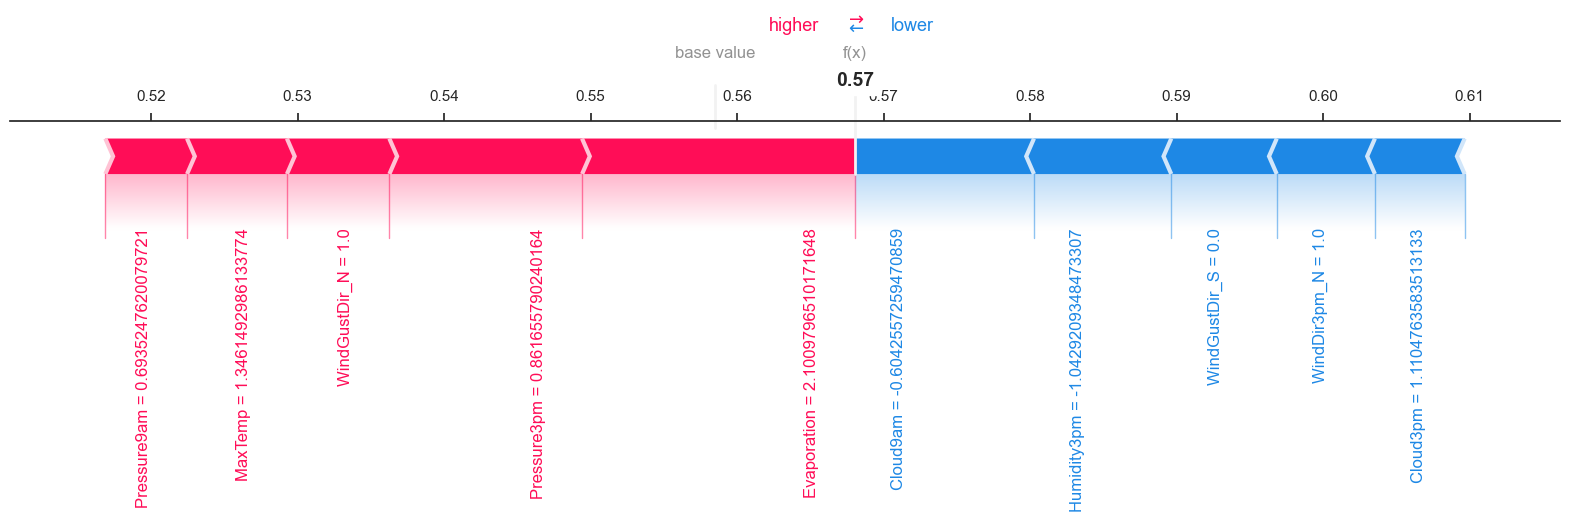

In [116]:
# Calcular valores SHAP
shap_values = explainer.shap_values(X_explain)

# Inicia entorno JS para visualizaciones
shap.initjs()

# Explicación local para la primera observación
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_explain.iloc[0],
    matplotlib=True,
    text_rotation=90
)

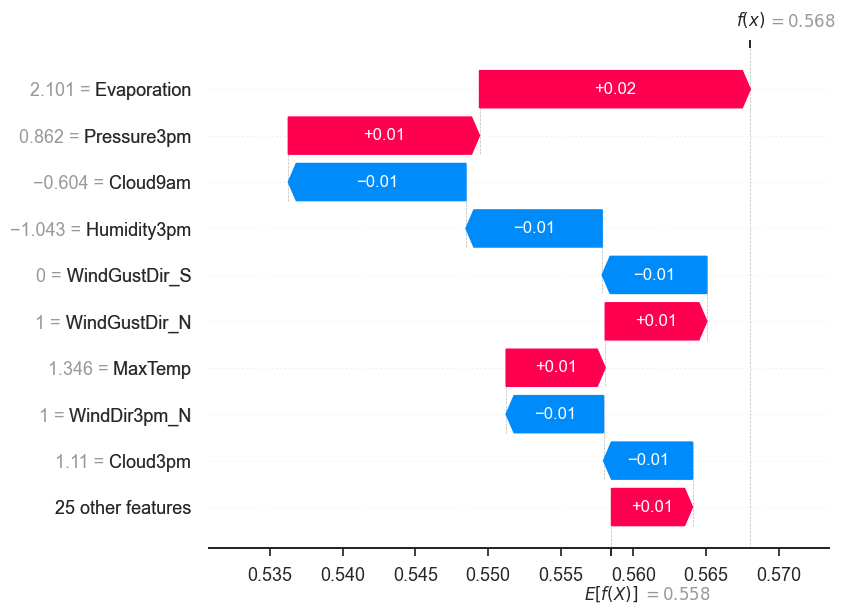

In [117]:
shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_explain.iloc[0]))

#### Explicabilidad global


PermutationExplainer explainer: 28081it [4:25:37,  1.76it/s]                                  


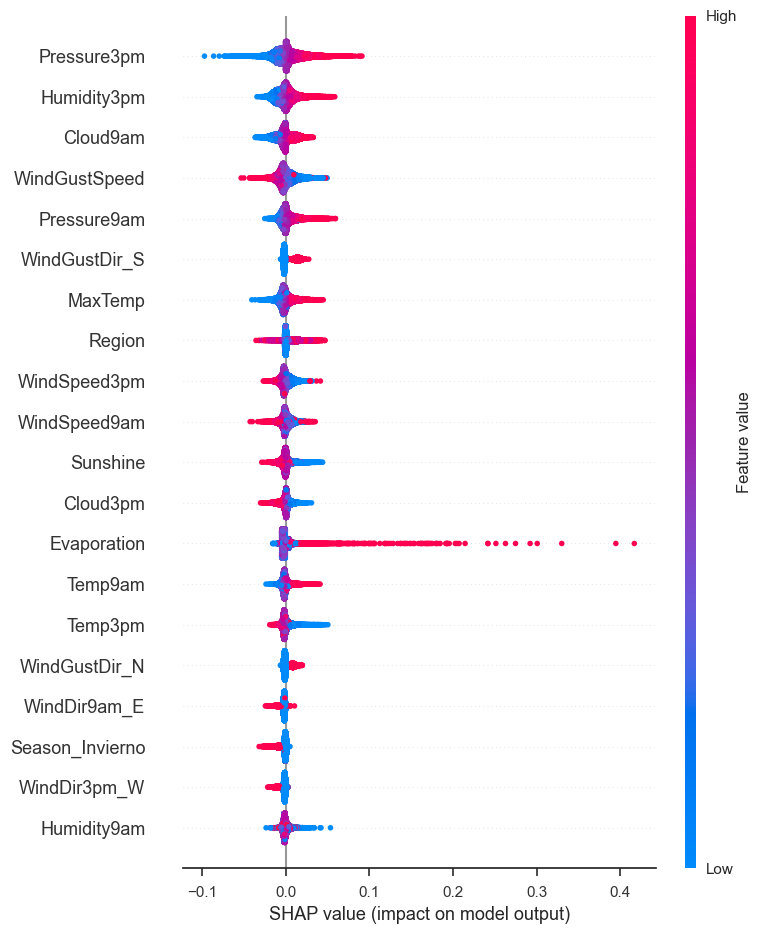

In [118]:
# Crear un explicador SHAP para el modelo
explainer = shap.Explainer(final_model, X_train_scaled)

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer(X_test_processed)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test_processed)

Type of shap_values: <class 'shap._explanation.Explanation'>


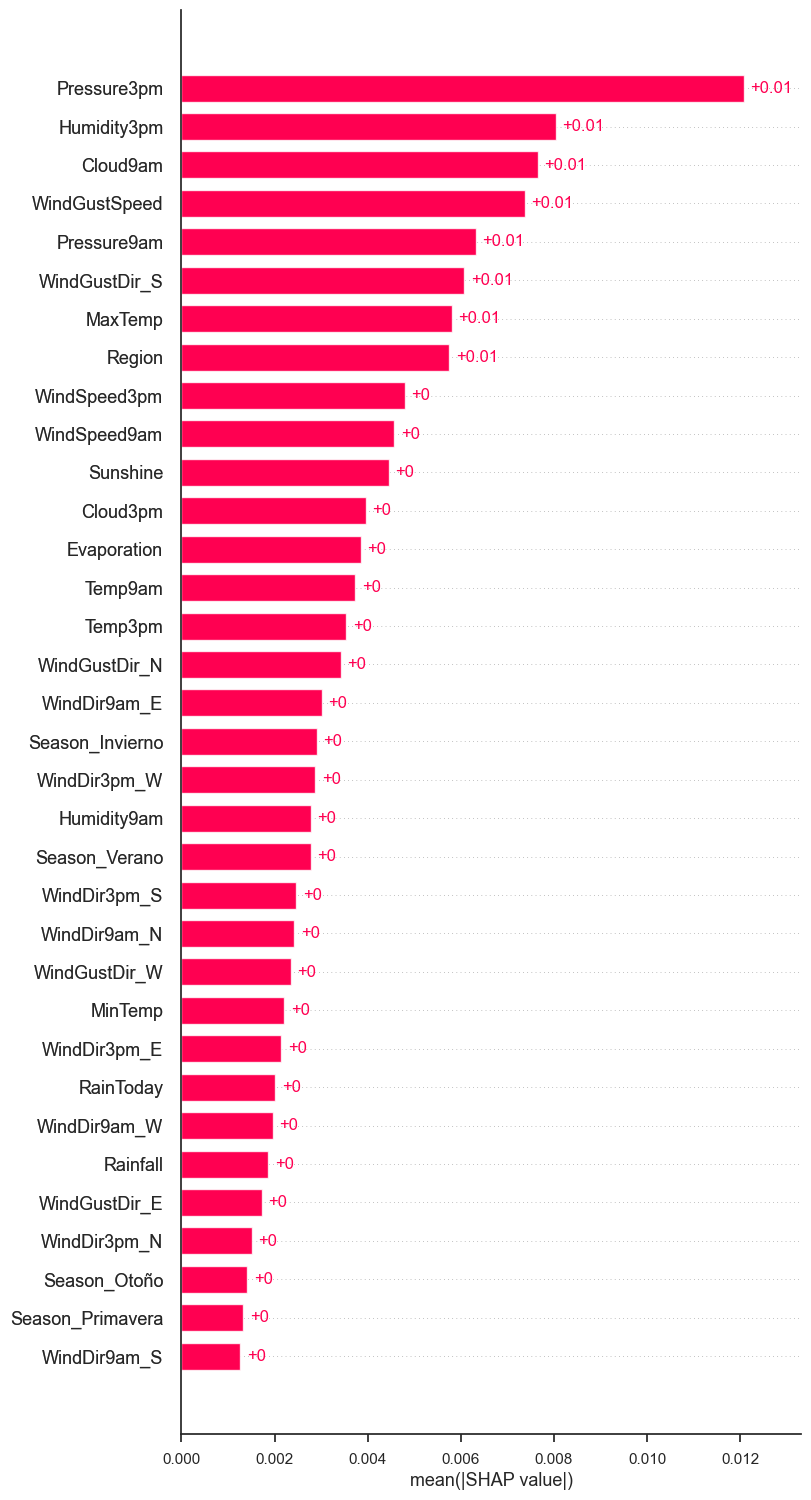

In [119]:
# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Crear la explicación para las importancias de las características globales
feature_names = X_test_processed.columns  
explanation = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=X_test_processed, feature_names=feature_names)

# Inicializar JS para gráficos interactivos 
shap.initjs()

# Visualizar la explicación de las importancias de las características 
shap.plots.bar(explanation, max_display=len(feature_names))

# Mostrar el gráfico
plt.show()

# Comparación de modelos




 |Modelo/Técnica                  | F1 Score
|----------------|----------|
|AutoML      |                   0.652|
|NN  |                           0.63|
|Best NN       |                 0.625|
|Logistic (sin regularización)|  0.602|
|Logistic (L2)      |            0.601|
|Logistic optimizada   |         0.597|
|Base (Dummy)           |        0.314|



###  Conclusión Final

En este trabajo se compararon distintos enfoques para resolver una tarea de clasificación, evaluando su rendimiento en función del F1 Score. Entre todas las técnicas exploradas, el proceso automatizado de AutoML se destacó como el más efectivo, alcanzando un F1 Score de 0.652, superando tanto a las redes neuronales como a los modelos de regresión logística, incluso cuando estos últimos fueron regularizados y optimizados.

Si bien se entrenaron redes neuronales y se buscaron sus mejores configuraciones, los resultados obtenidos (F1 Score de 0.630 para la versión base y 0.6251 para la versión ajustada) no lograron superar al modelo generado automáticamente por AutoML. Esto sugiere que, para este problema en particular, los algoritmos y combinaciones evaluadas por AutoML lograron una mayor capacidad de generalización sin necesidad de ajustes manuales extensivos.

Por su parte, los modelos de regresión logística obtuvieron desempeños similares entre sí (F1 Scores entre 0.597 y 0.602), y superaron al modelo base (Dummy, con F1 Score de 0.314), aunque sin alcanzar niveles competitivos en comparación con AutoML o redes neuronales.

En resumen, los resultados justifican la decisión de implementar el modelo seleccionado por AutoML en producción, ya que no solo ofreció el mejor rendimiento, sino que también redujo significativamente el tiempo de experimentación, haciendo más eficiente el pipeline de desarrollo. Este modelo será empaquetado mediante Docker y desplegado siguiendo prácticas de MLOps para asegurar su reproducibilidad y escalabilidad.

Esto demuestra que, con las herramientas adecuadas, es posible alcanzar soluciones de alto rendimiento sin sacrificar eficiencia ni calidad en el proceso de desarrollo, marcando un camino claro hacia la automatización inteligente en proyectos de ciencia de datos.
